# 引言

<b>研究目的：</b>  
本文参考华泰研报《人工智能选股之支持向量机模型》，对研报里面的结果进行了分析，并研究了支持向量机模型（SVM）在多因子选股模型领域的应用，实现股票因子与收益之间非线性模型的建立，通过对模型进行多维度分析实现模型评价。  

<b>研究内容：</b>  
多因子模型的本质是关于股票当期因子暴露和未来收益之间的线性回归模型。我们希望引入机器学习的思想，对传统多因子模型进行优化。然而，由于金融市场是复杂的、非线性的，因此线性模型就会存在比较大的缺陷。线性支持向量机能够解决线性分类问题，核支持向量机则主要针对非线性分类问题，支持向量回归能够处理回归问题。本篇报告我们将支持向量机应用于多因子选股，主要关注如下几方面的问题:  
（1）首先是模型选择的问题：常见的核函数有线性核、多项式核、高斯核等，不同核函数的选择会构建不同的模型,如何确定核函数才能使模型更优。  
（2）其次是参数寻优的问题：支持向量机包含两个重要参数，即惩罚系数 C 和 gamma 值，如何确定最优参数。  
（3）然后是组合构建的问题：在衡量过不同支持向量机模型的表现之后，应如何利用模型的预测结果构建策略组合进行回测。  
（4）最后是模型评价的问题：在根据模型预测结果构建策略组合进行回测后，如何对回测结果进行评价，从而判断出模型的优劣。

<b>研究结论：</b>  
（1）本文以 HS300 成分股为标的，以 2010-2014 年的因子及下期收益作为样本内集合，2014 年 2018 年的数据为样本外测试集，高斯核 SVM 在 HS300 选股模型交叉验证集正确率为 56.2%，AUC 为 0.561，样本外测试集平均正确率为 55.1%，平均 AUC 为 0.550。  
（2）以 HS300 为票池，利用高斯核 SVM 模型构建选股策略。对于 HS300 成份股内选股的等权重策略以及行业中性策略。总体而言，高斯核 SVM 在收益、夏普比率、最大回测等方面分层明确，可见模型是有效的。  
（3）比较了不同核支持向量机 (SVM) 的预测能力，一般情况下，高斯核收益能力要高于其他核函数模型。
（4）比较了高斯核支持向量机 (SVM) 以及支持向量回归 (SVR) 的预测能力，绝大多数时候，高斯核 SVC 的收益能力比 SVR 模型更强。  

<b>研究耗时：</b>  
（1）数据准备部分：大约需要 8h，主要出现在数据采集部分，为了避免程序耗时过长，已将数据提前运行出来，下载地址：https://pan.baidu.com/s/1DSI7uc5yBNY3hzedu9L7mw  
（2）模型测试部分：大约需要 6h，主要耗时在参数交叉验证，该步骤可仅作为参考，直接跳过该步骤。  
（3）策略构建部分：大约需要 36min，主要回测组合较多，且行业中性较为复杂，耗时较多。


# 1 数据准备

## 1.1 日期列表获取（约 3 s）

在每个月的月末对因子数据进行提取，因此需要对每个月的月末日期进行统计。  
输入参数分别为 peroid、start_date 和 end_date，其中 peroid 进行周期选择，可选周期为周(W)、月(M)和季(Q)，start_date和end_date 分别为开始日期和结束日期。  
函数返回值为对应的月末日期。本文选取开始日期为 2010.1.1，结束日期为 2018.1.1。

In [2]:
from jqdata import *
from jqlib.technical_analysis import *
from jqfactor import get_factor_values
from jqfactor import winsorize_med
from jqfactor import standardlize
from jqfactor import neutralize
import datetime
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels import regression
import cPickle as pickle
from six import StringIO
#导入pca
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import seaborn as sns


In [3]:
#获取指定周期的日期列表 'W、M、Q'
def get_period_date(peroid,start_date, end_date):
    #设定转换周期period_type  转换为周是'W',月'M',季度线'Q',五分钟'5min',12天'12D'
    stock_data = get_price('000001.XSHE',start_date,end_date,'daily',fields=['close'])
    #记录每个周期中最后一个交易日
    stock_data['date']=stock_data.index
    #进行转换，周线的每个变量都等于那一周中最后一个交易日的变量值
    period_stock_data=stock_data.resample(peroid,how='last')
    date=period_stock_data.index
    pydate_array = date.to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
    date_only_series = pd.Series(date_only_array)
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    start_date=start_date-datetime.timedelta(days=1)
    start_date = start_date.strftime("%Y-%m-%d")
    date_list=date_only_series.values.tolist()
    date_list.insert(0,start_date)
    return date_list
np.array(get_period_date('M','2010-01-01', '2018-01-01'))


array(['2009-12-31', '2010-01-31', '2010-02-28', '2010-03-31',
       '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31',
       '2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30',
       '2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
       '2011-04-30', '2011-05-31', '2011-06-30', '2011-07-31',
       '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30',
       '2011-12-31', '2012-01-31', '2012-02-29', '2012-03-31',
       '2012-04-30', '2012-05-31', '2012-06-30', '2012-07-31',
       '2012-08-31', '2012-09-30', '2012-10-31', '2012-11-30',
       '2012-12-31', '2013-01-31', '2013-02-28', '2013-03-31',
       '2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31',
       '2013-08-31', '2013-09-30', '2013-10-31', '2013-11-30',
       '2013-12-31', '2014-01-31', '2014-02-28', '2014-03-31',
       '2014-04-30', '2014-05-31', '2014-06-30', '2014-07-31',
       '2014-08-31', '2014-09-30', '2014-10-31', '2014-11-30',
       '2014-12-31', '2015-01-31', '2015-02-28', '2015-

## 1.2 股票列表获取（约 2 s）

可选股票池: HS300、ZZ500、中证 800、创业板指以及全 A 股  
股票筛选：剔除 ST 股票，剔除上市 3 个月内的股票，每只股票视作一个样本  
以 HS300 为例，取 2017-06-01 当天的股票成分股

In [4]:
#去除上市距beginDate不足3个月的股票
def delect_stop(stocks,beginDate,n=30*3):
    stockList=[]
    beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
    for stock in stocks:
        start_date=get_security_info(stock).start_date
        if start_date<(beginDate-datetime.timedelta(days=n)).date():
            stockList.append(stock)
    return stockList
#获取股票池
def get_stock(stockPool,begin_date):
    if stockPool=='HS300':
        stockList=get_index_stocks('000300.XSHG',begin_date)
    elif stockPool=='ZZ500':
        stockList=get_index_stocks('399905.XSHE',begin_date)
    elif stockPool=='ZZ800':
        stockList=get_index_stocks('399906.XSHE',begin_date)   
    elif stockPool=='CYBZ':
        stockList=get_index_stocks('399006.XSHE',begin_date)
    elif stockPool=='ZXBZ':
        stockList=get_index_stocks('399005.XSHE',begin_date)
    elif stockPool=='A':
        stockList=get_index_stocks('000002.XSHG',begin_date)+get_index_stocks('399107.XSHE',begin_date)
    #剔除ST股
    st_data=get_extras('is_st',stockList, count = 1,end_date=begin_date)
    stockList = [stock for stock in stockList if not st_data[stock][0]]
    #剔除停牌、新股及退市股票
    stockList=delect_stop(stockList,begin_date)
    return stockList
get_stock('HS300','2017-06-01')

[u'000001.XSHE',
 u'000002.XSHE',
 u'000008.XSHE',
 u'000009.XSHE',
 u'000027.XSHE',
 u'000039.XSHE',
 u'000060.XSHE',
 u'000061.XSHE',
 u'000063.XSHE',
 u'000069.XSHE',
 u'000100.XSHE',
 u'000156.XSHE',
 u'000157.XSHE',
 u'000166.XSHE',
 u'000333.XSHE',
 u'000338.XSHE',
 u'000402.XSHE',
 u'000413.XSHE',
 u'000415.XSHE',
 u'000423.XSHE',
 u'000425.XSHE',
 u'000503.XSHE',
 u'000538.XSHE',
 u'000540.XSHE',
 u'000555.XSHE',
 u'000559.XSHE',
 u'000568.XSHE',
 u'000623.XSHE',
 u'000625.XSHE',
 u'000627.XSHE',
 u'000630.XSHE',
 u'000651.XSHE',
 u'000671.XSHE',
 u'000686.XSHE',
 u'000709.XSHE',
 u'000712.XSHE',
 u'000718.XSHE',
 u'000725.XSHE',
 u'000728.XSHE',
 u'000738.XSHE',
 u'000750.XSHE',
 u'000768.XSHE',
 u'000776.XSHE',
 u'000778.XSHE',
 u'000783.XSHE',
 u'000792.XSHE',
 u'000793.XSHE',
 u'000800.XSHE',
 u'000826.XSHE',
 u'000839.XSHE',
 u'000858.XSHE',
 u'000876.XSHE',
 u'000895.XSHE',
 u'000917.XSHE',
 u'000938.XSHE',
 u'000963.XSHE',
 u'000977.XSHE',
 u'000983.XSHE',
 u'001979.XSHE

## 1.3 特征提取及特征预处理（约 8 h）

特征提取: 每个自然月的最后一个交易日，计算之前报告里的 66 个因子暴露度（其中wind因子数据无法提取，股东因子存在缺失较多，暂不提取），作为样本的原始特征。  
特征预处理:  
(1) 中位数去极值: 设第 T 期某因子在所有个股上的暴露度序列为 𝐷𝑖 ，𝐷𝑀 为该序列中位数，𝐷𝑀1 为序列|𝐷𝑖-𝐷𝑀|的中位数，则将序列𝐷𝑖中所有大于 𝐷𝑀+5𝐷𝑀1 的数重设为 𝐷𝑀+5𝐷𝑀1，将序列 𝐷𝑖 中所有小于 𝐷𝑀-5𝐷𝑀1 的数重设为 𝐷𝑀-5𝐷𝑀1，本文采用聚宽的函数库 winsorize_med() 实现该功能。  
(2) 缺失值处理: 得到新的因子暴露度序列后，将因子暴露度缺失的地方设为申万一级行业相同个股的平均值，通过函数 replace_nan_indu() 实现该功能。  
(3) 行业市值中性化: 将填充缺失值后的因子暴露度对行业哑变量和取对数后的市值做线性回归，取残差作为新的因子暴露度，通过聚宽函数库 neutralize() 实现该功能。  
(4) 标准化: 将中性化处理后的因子暴露度序列减去其现在的均值、除以其标准差，得到一个新的近似服从 N(0,1) 分布的序列，通过聚宽函数库 standardlize() 实现该功能。  
注：考虑到时间运行时间较长，已将数据提前运行出来，下载地址：https://pan.baidu.com/s/1DSI7uc5yBNY3hzedu9L7mw


In [ ]:
# 辅助线性回归的函数
def linreg(X,Y,columns=3):
    X=sm.add_constant(array(X))
    Y=array(Y)
    if len(Y)>1:
        results = regression.linear_model.OLS(Y, X).fit()
        return results.params
    else:
        return [float("nan")]*(columns+1)
#取股票对应行业
def get_industry_name(i_Constituent_Stocks, value):
    return [k for k, v in i_Constituent_Stocks.items() if value in v]

#缺失值处理
def replace_nan_indu(factor_data,stockList,industry_code,date):
    #把nan用行业平均值代替，依然会有nan，此时用所有股票平均值代替
    i_Constituent_Stocks={}
    data_temp=pd.DataFrame(index=industry_code,columns=factor_data.columns)
    for i in industry_code:
        temp = get_industry_stocks(i, date)
        i_Constituent_Stocks[i] = list(set(temp).intersection(set(stockList)))
        data_temp.loc[i]=mean(factor_data.loc[i_Constituent_Stocks[i],:])
    for factor in data_temp.columns:
        #行业缺失值用所有行业平均值代替
        null_industry=list(data_temp.loc[pd.isnull(data_temp[factor]),factor].keys())
        for i in null_industry:
            data_temp.loc[i,factor]=mean(data_temp[factor])
        null_stock=list(factor_data.loc[pd.isnull(factor_data[factor]),factor].keys())
        for i in null_stock:
            industry=get_industry_name(i_Constituent_Stocks, i)
            if industry:
                factor_data.loc[i,factor]=data_temp.loc[industry[0],factor] 
            else:
                factor_data.loc[i,factor]=mean(factor_data[factor])
    return factor_data

#数据预处理
def data_preprocessing(factor_data,stockList,industry_code,date):
    #去极值
    factor_data=winsorize_med(factor_data, scale=5, inf2nan=False,axis=0)
    #缺失值处理
    factor_data=replace_nan_indu(factor_data,stockList,industry_code,date)
    #中性化处理
    factor_data=neutralize(factor_data, how=['sw_l1', 'market_cap'], date=date, axis=0)
    #标准化处理
    factor_data=standardlize(factor_data,axis=0)
    return factor_data

#获取时间为date的全部因子数据
def get_factor_data(stock,date):
    data=pd.DataFrame(index=stock)
    q = query(valuation,balance,cash_flow,income,indicator).filter(valuation.code.in_(stock))
    df = get_fundamentals(q, date)
    df['market_cap']=df['market_cap']*100000000
    factor_data=get_factor_values(stock,['roe_ttm','roa_ttm','total_asset_turnover_rate',\
                               'net_operate_cash_flow_ttm','net_profit_ttm',\
                              'cash_to_current_liability','current_ratio',\
                             'gross_income_ratio','non_recurring_gain_loss',\
                            'operating_revenue_ttm','net_profit_growth_rate'],end_date=date,count=1)
    factor=pd.DataFrame(index=stock)
    for i in factor_data.keys():
        factor[i]=factor_data[i].iloc[0,:]
    df.index = df['code']
    del df['code'],df['id']
    #合并得大表
    df=pd.concat([df,factor],axis=1)
    #净利润(TTM)/总市值
    data['EP']=df['net_profit_ttm']/df['market_cap']
    #净资产/总市值
    data['BP']=1/df['pb_ratio']
    #营业收入(TTM)/总市值
    data['SP']=1/df['ps_ratio']
    #净现金流(TTM)/总市值
    data['NCFP']=1/df['pcf_ratio']
    #经营性现金流(TTM)/总市值
    data['OCFP']=df['net_operate_cash_flow_ttm']/df['market_cap']
    #净利润(TTM)同比增长率/PE_TTM
    data['G/PE']=df['net_profit_growth_rate']/df['pe_ratio']
    #ROE_ttm
    data['roe_ttm']=df['roe_ttm']
    #ROE_YTD
    data['roe_q']=df['roe']
    #ROA_ttm
    data['roa_ttm']=df['roa_ttm']
    #ROA_YTD
    data['roa_q']=df['roa']
    #毛利率TTM
    data['grossprofitmargin_ttm']=df['gross_income_ratio']
    #毛利率YTD
    data['grossprofitmargin_q']=df['gross_profit_margin']

    #扣除非经常性损益后净利润率YTD
    data['profitmargin_q']=df['adjusted_profit']/df['operating_revenue']
    #资产周转率TTM
    data['assetturnover_ttm']=df['total_asset_turnover_rate']
    #资产周转率YTD 营业收入/总资产
    data['assetturnover_q']=df['operating_revenue']/df['total_assets']
    #经营性现金流/净利润TTM
    data['operationcashflowratio_ttm']=df['net_operate_cash_flow_ttm']/df['net_profit_ttm']
    #经营性现金流/净利润YTD
    data['operationcashflowratio_q']=df['net_operate_cash_flow']/df['net_profit']
    #净资产
    df['net_assets']=df['total_assets']-df['total_liability']
    #总资产/净资产
    data['financial_leverage']=df['total_assets']/df['net_assets']
    #非流动负债/净资产
    data['debtequityratio']=df['total_non_current_liability']/df['net_assets']
    #现金比率=(货币资金+有价证券)÷流动负债
    data['cashratio']=df['cash_to_current_liability']
    #流动比率=流动资产/流动负债*100%
    data['currentratio']=df['current_ratio']
    #总市值取对数
    data['ln_capital']=np.log(df['market_cap'])
    #TTM所需时间
    his_date = [pd.to_datetime(date) - datetime.timedelta(90*i) for i in range(0, 4)]
    tmp = pd.DataFrame()
    tmp['code']=stock
    for i in his_date:
        tmp_adjusted_dividend = get_fundamentals(query(indicator.code, indicator.adjusted_profit, \
                                                     cash_flow.dividend_interest_payment).
                                               filter(indicator.code.in_(stock)), date = i)
        tmp=pd.merge(tmp,tmp_adjusted_dividend,how='outer',on='code')

        tmp=tmp.rename(columns={'adjusted_profit':'adjusted_profit'+str(i.month), \
                                'dividend_interest_payment':'dividend_interest_payment'+str(i.month)})
    tmp=tmp.set_index('code')
    tmp_columns=tmp.columns.values.tolist()
    tmp_adjusted=sum(tmp[[i for i in tmp_columns if 'adjusted_profit'in i ]],1)
    tmp_dividend=sum(tmp[[i for i in tmp_columns if 'dividend_interest_payment'in i ]],1)
    #扣除非经常性损益后净利润(TTM)/总市值
    data['EPcut']=tmp_adjusted/df['market_cap']
    #近12个月现金红利(按除息日计)/总市值
    data['DP']=tmp_dividend/df['market_cap']
    #扣除非经常性损益后净利润率TTM
    data['profitmargin_ttm']=tmp_adjusted/df['operating_revenue_ttm']
    #营业收入(YTD)同比增长率
    #_x现在 _y前一年
    his_date = pd.to_datetime(date) - datetime.timedelta(365)
    name=['operating_revenue','net_profit','net_operate_cash_flow','roe']
    temp_data=df[name]
    his_temp_data = get_fundamentals(query(valuation.code, income.operating_revenue,income.net_profit,\
                                            cash_flow.net_operate_cash_flow,indicator.roe).
                                      filter(valuation.code.in_(stock)), date = his_date)
    his_temp_data=his_temp_data.set_index('code')
    #重命名 his_temp_data last_year
    for i in name:
        his_temp_data=his_temp_data.rename(columns={i:i+'last_year'})

    temp_data =pd.concat([temp_data,his_temp_data],axis=1)
    #营业收入(YTD)同比增长率
    data['sales_g_q']=temp_data['operating_revenue']/temp_data['operating_revenuelast_year']-1
    #净利润(YTD)同比增长率
    data['profit_g_q']=temp_data['net_profit']/temp_data['net_profitlast_year']-1
    #经营性现金流(YTD)同比增长率
    data['ocf_g_q']=temp_data['net_operate_cash_flow']/temp_data['net_operate_cash_flowlast_year']-1
    #ROE(YTD)同比增长率
    data['roe_g_q']=temp_data['roe']/temp_data['roelast_year']-1
    #个股60个月收益与上证综指回归的截距项与BETA
    stock_close=get_price(stock, count = 60*20+1, end_date=date, frequency='daily', fields=['close'])['close']
    SZ_close=get_price('000001.XSHG', count = 60*20+1, end_date=date, frequency='daily', fields=['close'])['close']
    stock_pchg=stock_close.pct_change().iloc[1:]
    SZ_pchg=SZ_close.pct_change().iloc[1:]
    beta=[]
    stockalpha=[]
    for i in stock:
        temp_beta, temp_stockalpha = stats.linregress(SZ_pchg, stock_pchg[i])[:2]
        beta.append(temp_beta)
        stockalpha.append(temp_stockalpha)
    #此处alpha beta为list
    data['alpha']=stockalpha
    data['beta']=beta

    #动量
    data['return_1m']=stock_close.iloc[-1]/stock_close.iloc[-20]-1
    data['return_3m']=stock_close.iloc[-1]/stock_close.iloc[-60]-1
    data['return_6m']=stock_close.iloc[-1]/stock_close.iloc[-120]-1
    data['return_12m']=stock_close.iloc[-1]/stock_close.iloc[-240]-1

    #取换手率数据
    data_turnover_ratio=pd.DataFrame()
    data_turnover_ratio['code']=stock
    trade_days=list(get_trade_days(end_date=date, count=240*2))
    for i in trade_days:
        q = query(valuation.code,valuation.turnover_ratio).filter(valuation.code.in_(stock))
        temp = get_fundamentals(q, i)
        data_turnover_ratio=pd.merge(data_turnover_ratio, temp,how='left',on='code')
        data_turnover_ratio=data_turnover_ratio.rename(columns={'turnover_ratio':i})
    data_turnover_ratio=data_turnover_ratio.set_index('code').T   

    #个股个股最近N个月内用每日换手率乘以每日收益率求算术平均值
    data['wgt_return_1m']=mean(stock_pchg.iloc[-20:]*data_turnover_ratio.iloc[-20:])
    data['wgt_return_3m']=mean(stock_pchg.iloc[-60:]*data_turnover_ratio.iloc[-60:])
    data['wgt_return_6m']=mean(stock_pchg.iloc[-120:]*data_turnover_ratio.iloc[-120:])
    data['wgt_return_12m']=mean(stock_pchg.iloc[-240:]*data_turnover_ratio.iloc[-240:])
    #个股个股最近N个月内用每日换手率乘以函数exp(-x_i/N/4)再乘以每日收益率求算术平均值
    temp_data=pd.DataFrame(index=data_turnover_ratio[-240:].index,columns=stock)
    temp=[]
    for i in range(240):
        if i/20<1:
            temp.append(exp(-i/1/4))
        elif i/20<3:
            temp.append(exp(-i/3/4))
        elif i/20<6:
            temp.append(exp(-i/6/4))
        elif i/20<12:
            temp.append(exp(-i/12/4))  
    temp.reverse()
    for i in stock:
        temp_data[i]=temp
    data['exp_wgt_return_1m']=mean(stock_pchg.iloc[-20:]*temp_data.iloc[-20:]*data_turnover_ratio.iloc[-20:])
    data['exp_wgt_return_3m']=mean(stock_pchg.iloc[-60:]*temp_data.iloc[-60:]*data_turnover_ratio.iloc[-60:])
    data['exp_wgt_return_6m']=mean(stock_pchg.iloc[-120:]*temp_data.iloc[-120:]*data_turnover_ratio.iloc[-120:])
    data['exp_wgt_return_12m']=mean(stock_pchg.iloc[-240:]*temp_data.iloc[-240:]*data_turnover_ratio.iloc[-240:])

    #特异波动率
    #获取FF三因子残差数据
    LoS=len(stock)
    S=df.sort('market_cap')[:LoS/3].index
    B=df.sort('market_cap')[LoS-LoS/3:].index
    df['BTM']=df['total_owner_equities']/df['market_cap']
    L=df.sort('BTM')[:LoS/3].index
    H=df.sort('BTM')[LoS-LoS/3:].index
    df_temp=stock_pchg.iloc[-240:]
    #求因子的值
    SMB=sum(df_temp[S].T)/len(S)-sum(df_temp[B].T)/len(B)
    HMI=sum(df_temp[H].T)/len(H)-sum(df_temp[L].T)/len(L)
    #用沪深300作为大盘基准
    dp=get_price('000300.XSHG',count=12*20+1,end_date=date,frequency='daily', fields=['close'])['close']
    RM=dp.pct_change().iloc[1:]-0.04/252
    #将因子们计算好并且放好
    X=pd.DataFrame({"RM":RM,"SMB":SMB,"HMI":HMI})
    resd=pd.DataFrame()
    for i in stock:
        temp=df_temp[i]-0.04/252
        t_r=linreg(X,temp)
        resd[i]=list(temp-(t_r[0]+X.iloc[:,0]*t_r[1]+X.iloc[:,1]*t_r[2]+X.iloc[:,2]*t_r[3]))
    data['std_FF3factor_1m']=resd[-1*20:].std()
    data['std_FF3factor_3m']=resd[-3*20:].std()
    data['std_FF3factor_6m']=resd[-6*20:].std()
    data['std_FF3factor_12m']=resd[-12*20:].std()

    #波动率
    data['std_1m']=stock_pchg.iloc[-20:].std()
    data['std_3m']=stock_pchg.iloc[-60:].std()
    data['std_6m']=stock_pchg.iloc[-120:].std()
    data['std_12m']=stock_pchg.iloc[-240:].std()

    #股价
    data['ln_price']=np.log(stock_close.iloc[-1])

    #换手率
    data['turn_1m']=mean(data_turnover_ratio.iloc[-20:])
    data['turn_3m']=mean(data_turnover_ratio.iloc[-60:])
    data['turn_6m']=mean(data_turnover_ratio.iloc[-120:])
    data['turn_12m']=mean(data_turnover_ratio.iloc[-240:])

    data['bias_turn_1m']=mean(data_turnover_ratio.iloc[-20:])/mean(data_turnover_ratio)-1
    data['bias_turn_3m']=mean(data_turnover_ratio.iloc[-60:])/mean(data_turnover_ratio)-1
    data['bias_turn_6m']=mean(data_turnover_ratio.iloc[-120:])/mean(data_turnover_ratio)-1
    data['bias_turn_12m']=mean(data_turnover_ratio.iloc[-240:])/mean(data_turnover_ratio)-1
    #技术指标
    data['PSY']=pd.Series(PSY(stock, date, timeperiod=20))
    data['RSI']=pd.Series(RSI(stock, date, N1=20))
    data['BIAS']=pd.Series(BIAS(stock,date, N1=20)[0])
    dif,dea,macd=MACD(stock, date, SHORT = 10, LONG = 30, MID = 15)
    data['DIF']=pd.Series(dif)
    data['DEA']=pd.Series(dea)
    data['MACD']=pd.Series(macd)
    return data

peroid = 'M'
start_date = '2010-01-01'
end_date = '2018-01-01'
industry_old_code = ['801010','801020','801030','801040','801050','801080','801110','801120','801130','801140','801150',\
                    '801160','801170','801180','801200','801210','801230']
industry_new_code = ['801010','801020','801030','801040','801050','801080','801110','801120','801130','801140','801150',\
                    '801160','801170','801180','801200','801210','801230','801710','801720','801730','801740','801750',\
                   '801760','801770','801780','801790','801880','801890']

dateList = get_period_date(peroid,start_date, end_date)
factor_origl_data = {}
factor_solve_data = {}
for date in dateList:
    #获取行业因子数据
    if datetime.datetime.strptime(date,"%Y-%m-%d").date()<datetime.date(2014,2,21):
        industry_code=industry_old_code
    else:
        industry_code=industry_new_code
    stockList=get_stock('HS300',date)

    factor_origl_data[date] = get_factor_data(stockList,date)
    factor_solve_data[date] = data_preprocessing(factor_origl_data[date],stockList,industry_code,date)
content = pickle.dumps(factor_solve_data) 
write_file('factor_solve_data.pkl', content, append=False)
    

## 1.4 读取数据 （约 3 s）

特征数据经过预处理后，为了方便后续对数据进行处理，将数据保存为 pkl 文件。读取文件，文件格式如下所示：数据类型为 dict，key 为日期，value 为每一期对应的因子数据，格式为 dataframe，index 为股票列表，columns 为因子。   
注：可直接将pkl文件上传至研究环境，进行数据读取。


In [5]:
#使用pickle模块将数据对象保存到文件
pkl_file_read = read_file("factor_solve_data.pkl")
factor_data = pickle.load(StringIO(pkl_file_read))
factor_data['2009-12-31'].head()

,EP,BP,SP,NCFP,OCFP,G/PE,roe_ttm,roe_q,roa_ttm,roa_q,...,bias_turn_1m,bias_turn_3m,bias_turn_6m,bias_turn_12m,PSY,RSI,BIAS,DIF,DEA,MACD
000001.XSHE,0.028950,1.131116,0.197401,-1.261756,-2.181723,-0.684842,0.025820,1.701937,-0.272718,-0.194391,...,-0.698740,-0.666942,-0.357962,0.349568,1.148705,1.291735,-0.202865,-0.362807,-0.079355,-0.788347
000002.XSHE,0.246983,-0.479406,0.331701,0.110568,0.679921,-0.513610,-0.181344,-1.024590,-0.225544,-0.825526,...,0.752829,0.393239,0.429813,0.190625,-0.942532,-0.768319,0.125205,0.148512,0.022209,0.357588
000009.XSHE,-0.262468,-1.249222,-0.017061,0.214158,0.451111,-0.044448,-0.110604,-0.697583,-0.042721,-0.269572,...,-0.395701,-0.566032,-0.833514,-0.112768,-0.802378,-0.713272,-0.262686,0.283520,0.059975,0.630850
000012.XSHE,0.467468,0.901849,0.214317,-0.304663,0.498606,-0.487198,0.518937,1.500490,0.641853,1.789205,...,-0.586362,0.393510,0.987122,1.588373,1.631216,1.555538,0.422617,0.208753,0.557065,-0.721810
000021.XSHE,0.574750,1.552436,2.686058,-0.022736,0.135909,-0.522318,0.279071,0.115994,0.730127,0.608440,...,-0.660390,-1.038726,-1.097826,1.312336,0.818352,1.350547,0.126273,-0.598198,-0.618886,-0.184690


# 2  模型测试

对于 SVM 模型原理，可参考[量化课堂-SVM原理入门](https://www.joinquant.com/post/947cddc2c353527a01f75288d4fc64c6?f=stydy&m=math)，此处不再多加赘述。

## 2.1 标签设置及数据集分割 （约 10 s）

对于支持向量机模型，本文主要采用分类模型，因此需要将收益率数据转化为标签，在每个月末截面期，选取下月收益排前、后 30% 的股票分别作为正例 (𝑦 = 1)、负例 (𝑦 = −1)。  
为了对模型进行测试，需要对数据集进行分割，故将前 4 年数据样本合并，作为训练集，后 4 年数据样本作为测试集。

In [6]:
peroid='M'
start_date='2010-01-01'
end_date='2018-01-01'
industry_old_code=['801010','801020','801030','801040','801050','801080','801110','801120','801130','801140','801150',\
                    '801160','801170','801180','801200','801210','801230']
industry_new_code=['801010','801020','801030','801040','801050','801080','801110','801120','801130','801140','801150',\
                    '801160','801170','801180','801200','801210','801230','801710','801720','801730','801740','801750',\
                   '801760','801770','801780','801790','801880','801890']

dateList=get_period_date(peroid,start_date, end_date)

# 训练集数据
train_data=pd.DataFrame()
for date in dateList[:4*12]:
    traindf=factor_data[date]
    stockList=list(traindf.index)
    #取收益率数据
    data_close=get_price(stockList,date,dateList[dateList.index(date)+1],'1d','close')['close']
    traindf['pchg']=data_close.iloc[-1]/data_close.iloc[0]-1
    #剔除空值
    traindf=traindf.dropna()   
    #选取前后各30%的股票，剔除中间的噪声
    traindf=traindf.sort(columns='pchg')
    traindf=traindf.iloc[:len(traindf['pchg'])/10*3,:].append(traindf.iloc[len(traindf['pchg'])/10*7:,:])
    traindf['label']=list(traindf['pchg'].apply(lambda x:1 if x>np.mean(list(traindf['pchg'])) else -1))    
    if train_data.empty:
        train_data=traindf
    else:
        train_data=train_data.append(traindf)
        
# 测试集数据        
test_data={}
for date in dateList[4*12:-1]:
    testdf=factor_data[date]
    stockList=list(testdf.index)
    # 取收益率数据
    data_close=get_price(stockList,date,dateList[dateList.index(date)+1],'1d','close')['close']
    testdf['pchg']=data_close.iloc[-1]/data_close.iloc[0]-1
    #剔除空值
    testdf=testdf.dropna()   
    #选取前后各30%的股票，剔除中间的噪声
    testdf=testdf.sort(columns='pchg')
    testdf=testdf.iloc[:len(testdf['pchg'])/10*3,:].append(testdf.iloc[len(testdf['pchg'])/10*7:,:])
    testdf['label']=list(testdf['pchg'].apply(lambda x:1 if x>np.mean(list(testdf['pchg'])) else -1)) 
    test_data[date]=testdf
        

## 2.2 模型训练及测试 （约 6 h）

本文将前 4 年数据作为验证集，进行交叉验证，实现参数的设计，采用方法为 K 折交叉验证，将数据分成 K 组 (K=10) ，操作步骤如下：  
（1）随机抽取 1 组做为验证集（10%），剩余 K-1 组训练集（90%）；   
（2）训练集建立模型后，将验证集放到模型中，得到预测标签；  
（3）比较预测标签和实际标签，计算模型的评价指标（正确率、AUC 等）；  
（4）上述步骤 1-3 重复进行 n 次，对评价指标取均值，作为最后评价结果。

首先，确定核函数，核函数参数设定如下所示，用来比较不容核函数对模型的影响。

| 核函数 | 参数设定 |
| ----- | ------ | 
| 线性核 | C = 1e-4 | 
| 3 阶多项式核 | C = 0.003 gamma = 0.03 | 
| 7 阶多项式核 | C = 0.03  gamma = 0.01 | 
| 高斯核 | C = 1 gamma = 3e-5| 


考虑到高斯核函数能够将任意维数据映射到无穷维空间，因此高斯核函数应用更有意义。然后，确定模型参数，惩罚系数 C 和 gamma 值是支持向量机模型最重要的两个参数。我们希望同时对 C 和 gamma 值进行遍历，找到全局最优解。参数寻优最常用的方法是网格搜索。下面我们以 SVM 为例，展示网格搜索的过程。  
取 C = (0.01, 0.03, 0.1, 0.3, 1, 3, 10)，γ= (1e-4, 3e-4, 1e-3, 3e-3, 0.01, 0.03, 0.1, 0.3, 1)  
测试每一组 C 和 gamma 值，得到交叉验证集的 AUC 值。（约 6 h）

In [ ]:
target=train_data['label']
train=train_data.copy()
del train['pchg']
del train['label']

regressor = svm.SVC()
# SVM算法参数设计
parameters = {'kernel':['rbf'],'C':[0.01,0.03,0.1,0.3,1,3,10],\
              'gamma':[1e-4,3e-4,1e-3,3e-3,0.01,0.03,0.1,0.3,1]}
# 创建网格搜索 scoring:指定多个评估指标  cv: N折交叉验证
clf = GridSearchCV(regressor,parameters,scoring=['roc_auc'],cv=10)
clf.fit(np.array(train),np.array(target))

# 输出交叉验证的结果统计列表
print clf.cv_results_
# 输出每个模型的结果
print clf.grid_scores_
# 输出最佳模型结果
print clf.best_score_
# 输出最佳模型参数
print clf.best_params_


根据统计结果，选择 C=10，gamma=0.01，对前4年数据进行训练，在样本内进行交叉验证，预测结果如下所示。根据计算结果可知，高斯核 SVM 模型样本内训练集和交叉验证集合正确率分别为 81.9% 和 56.2%，AUC 分别为 0.819 和 0.561。（约 5 min）

In [7]:
# 迭代次数
m=10
# 获取特征及标签
target=train_data['label']
train=train_data.copy()
del train['pchg']
del train['label']
train.head()

train_score=[]
test_score=[]
train_auc=[]
test_auc=[]


# 获取模型
clf = svm.SVC(C=10,gamma=0.01,kernel='rbf')

for i in range(m):
    # 随机获取10%的数据作为交叉验证集
    X_train,X_test, y_train, y_test =train_test_split(np.array(train),\
                                                      np.array(target),test_size=0.1)
    # 模型训练
    clf.fit(X_train,y_train)
    # 模型预测
    train_predict=clf.predict(X_train)
    test_predict=clf.predict(X_test)
    # 样本内训练集正确率
    train_score.append(clf.score(X_train, y_train))
    # 交叉验证集正确率
    test_score.append(clf.score(X_test, y_test))
    # 样本内训练集auc值
    train_auc.append(metrics.roc_auc_score(y_train,train_predict)) 
    # 交叉验证集auc值
    test_auc.append(metrics.roc_auc_score(y_test,test_predict)) 
    
print '样本内训练集正确率：',mean(train_score)
print '交叉验证集正确率：',mean(test_score)
print '样本内训练集AUC：',mean(train_auc)
print '交叉验证集AUC：',mean(test_auc)



样本内训练集正确率： 0.819233716475
交叉验证集正确率： 0.561768082664
样本内训练集AUC： 0.818962233394
交叉验证集AUC： 0.56090763493


在后 4 年，每月末获取因子数据，放入模型中进行预测，并统计预测结果分别为：样本外测试正确率为 55.1% 及 AUC 均值为 55%，样本外正确率及 AUC 每个月变化曲线图如下所示。(约 1 min)

In [8]:
# 获取特征及标签
train_target=train_data['label']
train_feature=train_data.copy()
del train_feature['pchg']
del train_feature['label']

test_sample_predict={}
test_sample_score=[]
test_sample_auc=[]
test_sample_date=[]

# 获取模型
clf = svm.SVC(C=10,gamma=0.001,kernel='rbf')
# 模型训练
clf.fit(np.array(train_feature),np.array(train_target))

for date in dateList[4*12:-1]:
    test_sample_date.append(date)
    # 取样本外数据特征及标签
    test_target=test_data[date]['label']
    test_feature=test_data[date].copy()
    del test_feature['pchg']
    del test_feature['label']
    test_target=np.array(test_target)
    test_feature=np.array(test_feature)
    # 模型预测
    test_predict=clf.predict(test_feature)
    # 样本外预测结果
    test_sample_predict[date]=test_predict
    # 样本外正确率
    test_sample_score.append(clf.score(test_feature, test_target))
    # 样本外auc值
    test_sample_auc.append(metrics.roc_auc_score(test_target,test_predict))
print '测试集正确率：',mean(test_sample_score)
print '测试集AUC：',mean(test_sample_auc)    



测试集正确率： 0.550579287516
测试集AUC： 0.550073726195


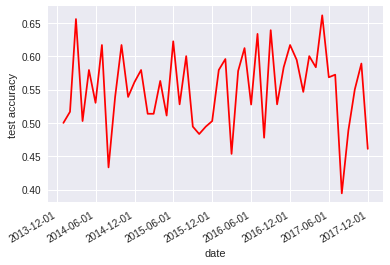

In [10]:
xs_date = [datetime.datetime.strptime(d, '%Y-%m-%d').date() for d in test_sample_date]
ys_score = test_sample_score
# 配置横坐标
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(xs_date, ys_score,'r')
# 自动旋转日期标记
plt.gcf().autofmt_xdate() 
# 横坐标标记
plt.xlabel('date')
# 纵坐标标记
plt.ylabel("test accuracy")
plt.show()


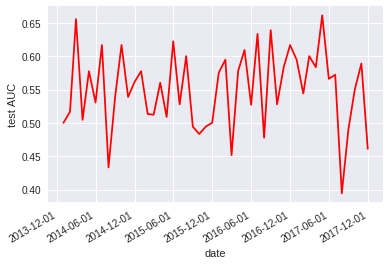

In [11]:
xs_date = [datetime.datetime.strptime(d, '%Y-%m-%d').date() for d in test_sample_date]
ys_auc = test_sample_auc
# 配置横坐标
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(xs_date, ys_auc,'r')
# 自动旋转日期标记
plt.gcf().autofmt_xdate() 
# 横坐标标记
plt.xlabel('date')
# 纵坐标标记
plt.ylabel("test AUC")
plt.show()


在每个截面上，将高斯核 SVM 模型 (C=1，γ=0.01) 对全部个股下期涨跌的预测值 与因子池中各个因子值之间计算相关系数，查看模型预测值与各个因子值之间 “真实的”相关情况，如下图所示。我们发现，超额收益预测值与换手率、技术等交易类因子关联性较弱，与基本面类型因子关联性较强。

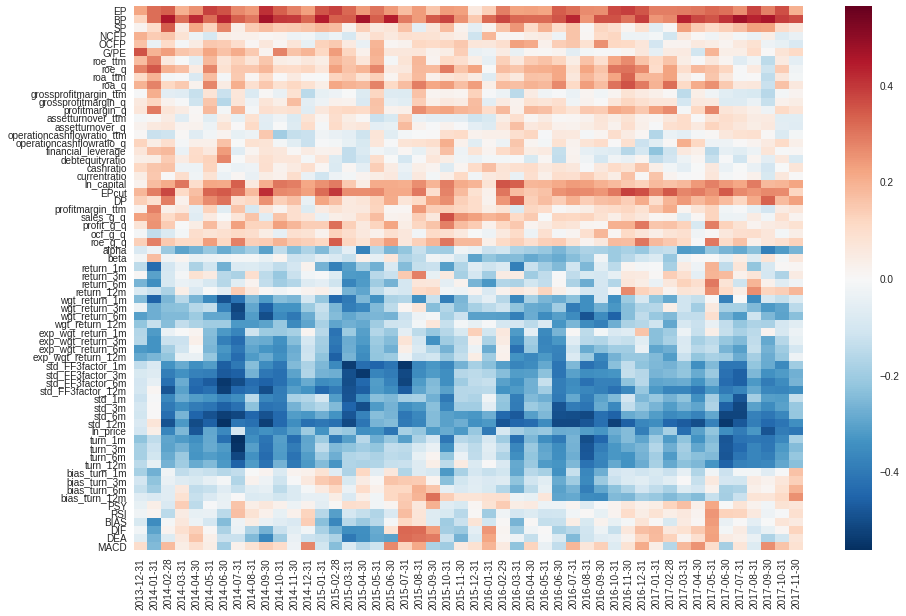

In [12]:
factor_predict_corr=pd.DataFrame()
for date in dateList[4*12:-1]:
    test_feature=test_data[date].copy()
    del test_feature['pchg']
    del test_feature['label']
    test_feature['predict']=list(test_sample_predict[date])
    factor_predict_corr[date]=test_feature.corr()['predict']    
factor_predict_corr=factor_predict_corr.iloc[:-1]
# 高斯核 SVM 模型对于下期涨跌预测值与本期因子值之间相关系数示意图
fig = plt.figure(figsize= (15,10))
ax = fig.add_subplot(111)
sns.set()
ax = sns.heatmap(factor_predict_corr)


## 2.3 小结

本部分主要进行 SVM 模型的测试。首先，对核函数进行分类，根据需求将核函数分为线性核、3 阶多项式核、7 阶多项式核以及高斯核四大类；然后设定一系列 C 和 gamma 值，通过交叉验证的方法，确定高斯核 SVM 模型的最佳参数，经过验证发现 C=10，gamma=0.01 时模型最佳；紧接着，利用模型分别对样本内数据及样本完数据进行检验，根据计算结果可知，高斯核 SVM 模型样本内训练集和交叉验证集合正确率分别为 81.9% 和 56.2%，AUC 分别为 0.819 和 0.561，样本外测试正确率为 55.1% 及 AUC 均值为 55%；最后，评估了模型预测收益率与因子之间的相关性，发现超额收益预测值与换手率、技术等交易类因子关联性较弱，与基本面类型因子关联性较强。

## 3 策略构建 （约 36 min）

沪深 300 成份股：剔除 ST、停牌、上市时间 <3 个月的股票  
回测时间：2014-01-01 至 2018-01-01  
调仓期：每月第一个交易日  
SVM 模型参数： 高斯核函数，C=10，γ=0.01  
选股：  
（1）利用 2010-2014 年数据建立 SVM 模型  
（2）利用 SVM 模型预测 2014-2018 年下月的收益  
（3）根据预测值选股投资  
评价方法: 回测年化收益率、夏普比率、最大回撤、胜率等。  
回测年化收益率: 年化收益率通常指投资一年后能够获得的收益率，由于回测时间的长短，往往会由于复利的影响导致长时间的总收益率更大，此时可通过年化收益率衡量模型的收益能力。   
夏普比率: 一般情况下，风险和收益总是背向而驰，模型在承担收益的同时也会承担相对应的风险，因此合理控制模型的收益与风险能够提高模型的优势。  
最大回撤: 最大回撤是指模型在过去的某一段时间可能出现的最大亏损程度，通常用来衡量模型的风险。在实际投资中，若是出现最大回撤较大的情况，往往会导致投资者对模型丧失信心，因此合理控制模型的最大回撤显得尤为重要。


### 3.1 等权重选股 （约 2 min）

策略步骤：  
（1）每月根据股票预测值进行排序  
（2）排序后将股票分为 N 层 (N=5)  
（3）按层级分别回测，每层股票等权重投资，得到 5 根回测曲线

In [2]:
#1 先导入所需要的程序包
import datetime
import numpy as np 
import pandas as pd
import time
from jqdata import *
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import copy
import pickle

# 定义类'参数分析'
class parameter_analysis(object):
    
    # 定义函数中不同的变量
    def __init__(self, algorithm_id=None):
        self.algorithm_id = algorithm_id            # 回测id
        
        self.params_df = pd.DataFrame()             # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX
        self.results = {}                           # 回测结果的回报率，key 为 params_df 的行序号，value 为
        self.evaluations = {}                       # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe
        self.backtest_ids = {}                      # 回测结果的 id
        
        # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准
        self.benchmark_id = 'ae0684d86e9e7128b1ab9c7d77893029'                      
        
        self.benchmark_returns = []                 # 新加入的基准的回测回报率
        self.returns = {}                           # 记录所有回报率
        self.excess_returns = {}                    # 记录超额收益率
        self.log_returns = {}                       # 记录收益率的 log 值
        self.log_excess_returns = {}                # 记录超额收益的 log 值
        self.dates = []                             # 回测对应的所有日期
        self.excess_max_drawdown = {}               # 计算超额收益的最大回撤
        self.excess_annual_return = {}              # 计算超额收益率的年化指标
        self.evaluations_df = pd.DataFrame()        # 记录各项回测指标，除日回报率外
    
    # 定义排队运行多参数回测函数
    def run_backtest(self,                          #
                     algorithm_id=None,             # 回测策略id
                     running_max=10,                # 回测中同时巡行最大回测数量
                     start_date='2006-01-01',       # 回测的起始日期
                     end_date='2016-11-30',         # 回测的结束日期
                     frequency='day',               # 回测的运行频率
                     initial_cash='1000000',        # 回测的初始持仓金额
                     param_names=[],                # 回测中调整参数涉及的变量
                     param_values=[]                # 回测中每个变量的备选参数值
                     ):
        # 当此处回测策略的 id 没有给出时，调用类输入的策略 id
        if algorithm_id == None: algorithm_id=self.algorithm_id
        
        # 生成所有参数组合并加载到 df 中
        # 包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list
        param_combinations = list(itertools.product(*param_values))
        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值
        to_run_df = pd.DataFrame(param_combinations)
        # 修改列名称为调参变量的名字
        to_run_df.columns = param_names
        
        # 设定运行起始时间和保存格式
        start = time.time()
        # 记录结束的运行回测
        finished_backtests = {}
        # 记录运行中的回测
        running_backtests = {}
        # 计数器
        pointer = 0
        # 总运行回测数目，等于排列组合中的元素个数
        total_backtest_num = len(param_combinations)
        # 记录回测结果的回报率
        all_results = {}
        # 记录回测结果的各项指标
        all_evaluations = {}
        
        # 在运行开始时显示
        print '【已完成|运行中|待运行】:', 
        # 当运行回测开始后，如果没有全部运行完全的话：
        while len(finished_backtests)<total_backtest_num:
            # 显示运行、完成和待运行的回测个数
            print('[%s|%s|%s].' % (len(finished_backtests), 
                                   len(running_backtests), 
                                   (total_backtest_num-len(finished_backtests)-len(running_backtests)) )),
            # 记录当前运行中的空位数量
            to_run = min(running_max-len(running_backtests), total_backtest_num-len(running_backtests)-len(finished_backtests))
            # 把可用的空位进行跑回测
            for i in range(pointer, pointer+to_run):
                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值
                params = to_run_df.ix[i].to_dict()
                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容
                backtest = create_backtest(algorithm_id = algorithm_id,
                                           start_date = start_date, 
                                           end_date = end_date, 
                                           frequency = frequency, 
                                           initial_cash = initial_cash, 
                                           extras = params, 
                                           # 再回测中把改参数的结果起一个名字，包含了所有涉及的变量参数值
                                           name = str(params)
                                           )
                # 记录运行中 i 回测的回测 id
                running_backtests[i] = backtest
            # 计数器计数运行完的数量    
            pointer = pointer+to_run
            
            # 获取回测结果
            failed = []
            finished = []
            # 对于运行中的回测，key 为 to_run_df 中所有排列组合中的序数
            for key in running_backtests.keys():
                # 研究调用回测的结果，running_backtests[key] 为运行中保存的结果 id
                bt = get_backtest(running_backtests[key])
                # 获得运行回测结果的状态，成功和失败都需要运行结束后返回，如果没有返回则运行没有结束
                status = bt.get_status()
                # 当运行回测失败
                if status == 'failed':
                    # 失败 list 中记录对应的回测结果 id
                    failed.append(key)
                # 当运行回测成功时
                elif status == 'done':
                    # 成功 list 记录对应的回测结果 id，finish 仅记录运行成功的
                    finished.append(key)
                    # 回测回报率记录对应回测的回报率 dict， key to_run_df 中所有排列组合中的序数， value 为回报率的 dict
                    # 每个 value 一个 list 每个对象为一个包含时间、日回报率和基准回报率的 dict
                    all_results[key] = bt.get_results()
                    # 回测回报率记录对应回测结果指标 dict， key to_run_df 中所有排列组合中的序数， value 为回测结果指标的 dataframe
                    all_evaluations[key] = bt.get_risk()
            # 记录运行中回测结果 id 的 list 中删除失败的运行
            for key in failed:
                running_backtests.pop(key)
            # 在结束回测结果 dict 中记录运行成功的回测结果 id，同时在运行中的记录中删除该回测
            for key in finished:
                finished_backtests[key] = running_backtests.pop(key)
            # 当一组同时运行的回测结束时报告时间
            if len(finished_backtests) != 0 and len(finished_backtests) % running_max == 0 and to_run !=0:
                # 记录当时时间
                middle = time.time()
                # 计算剩余时间，假设没工作量时间相等的话
                remain_time = (middle - start) * (total_backtest_num - len(finished_backtests)) / len(finished_backtests)
                # print 当前运行时间
                print('[已用%s时,尚余%s时,请不要关闭浏览器].' % (str(round((middle - start) / 60.0 / 60.0,3)), 
                                          str(round(remain_time / 60.0 / 60.0,3)))),
            # 5秒钟后再跑一下
            time.sleep(5) 
        # 记录结束时间
        end = time.time() 
        print ''
        print('【回测完成】总用时：%s秒(即%s小时)。' % (str(int(end-start)), 
                                           str(round((end-start)/60.0/60.0,2)))),
        # 对应修改类内部对应
        self.params_df = to_run_df
        self.results = all_results
        self.evaluations = all_evaluations
        self.backtest_ids = finished_backtests

        
    #7 最大回撤计算方法
    def find_max_drawdown(self, returns):
        # 定义最大回撤的变量
        result = 0
        # 记录最高的回报率点
        historical_return = 0
        # 遍历所有日期
        for i in range(len(returns)):
            # 最高回报率记录
            historical_return = max(historical_return, returns[i])
            # 最大回撤记录
            drawdown = 1-(returns[i] + 1) / (historical_return + 1)
            # 记录最大回撤
            result = max(drawdown, result)
        # 返回最大回撤值
        return result

    # log 收益、新基准下超额收益和相对与新基准的最大回撤
    def organize_backtest_results(self, benchmark_id=None):
        # 若新基准的回测结果 id 没给出
        if benchmark_id==None:
            # 使用默认的基准回报率，默认的基准在回测策略中设定
            self.benchmark_returns = [x['benchmark_returns'] for x in self.results[0]]
        # 当新基准指标给出后    
        else:
            # 基准使用新加入的基准回测结果
            self.benchmark_returns = [x['returns'] for x in get_backtest(benchmark_id).get_results()]
        # 回测日期为结果中记录的第一项对应的日期
        self.dates = [x['time'] for x in self.results[0]]
        
        # 对应每个回测在所有备选回测中的顺序 （key），生成新数据
        # 由 {key：{u'benchmark_returns': 0.022480100091729405,
        #           u'returns': 0.03184566700000002,
        #           u'time': u'2006-02-14'}} 格式转化为：
        # {key: []} 格式，其中 list 为对应 date 的一个回报率 list
        for key in self.results.keys():
            self.returns[key] = [x['returns'] for x in self.results[key]]
        # 生成对于基准（或新基准）的超额收益率
        for key in self.results.keys():
            self.excess_returns[key] = [(x+1)/(y+1)-1 for (x,y) in zip(self.returns[key], self.benchmark_returns)]
        # 生成 log 形式的收益率
        for key in self.results.keys():
            self.log_returns[key] = [log(x+1) for x in self.returns[key]]
        # 生成超额收益率的 log 形式
        for key in self.results.keys():
            self.log_excess_returns[key] = [log(x+1) for x in self.excess_returns[key]]
        # 生成超额收益率的最大回撤
        for key in self.results.keys():
            self.excess_max_drawdown[key] = self.find_max_drawdown(self.excess_returns[key])
        # 生成年化超额收益率
        for key in self.results.keys():
            self.excess_annual_return[key] = (self.excess_returns[key][-1]+1)**(252./float(len(self.dates)))-1
        # 把调参数据中的参数组合 df 与对应结果的 df 进行合并
        self.evaluations_df = pd.concat([self.params_df, pd.DataFrame(self.evaluations).T], axis=1)
#         self.evaluations_df = 

    # 获取最总分析数据，调用排队回测函数和数据整理的函数    
    def get_backtest_data(self,
                          algorithm_id=None,                         # 回测策略id
                          benchmark_id=None,                         # 新基准回测结果id
                          file_name='results.pkl',                   # 保存结果的 pickle 文件名字
                          running_max=10,                            # 最大同时运行回测数量
                          start_date='2006-01-01',                   # 回测开始时间
                          end_date='2016-11-30',                     # 回测结束日期
                          frequency='day',                           # 回测的运行频率
                          initial_cash='1000000',                    # 回测初始持仓资金
                          param_names=[],                            # 回测需要测试的变量
                          param_values=[]                            # 对应每个变量的备选参数
                          ):
        # 调运排队回测函数，传递对应参数
        self.run_backtest(algorithm_id=algorithm_id,
                          running_max=running_max,
                          start_date=start_date,
                          end_date=end_date,
                          frequency=frequency,
                          initial_cash=initial_cash,
                          param_names=param_names,
                          param_values=param_values
                          )
        # 回测结果指标中加入 log 收益率和超额收益率等指标
        self.organize_backtest_results(benchmark_id)
        # 生成 dict 保存所有结果。
        results = {'returns':self.returns,
                   'excess_returns':self.excess_returns,
                   'log_returns':self.log_returns,
                   'log_excess_returns':self.log_excess_returns,
                   'dates':self.dates,
                   'benchmark_returns':self.benchmark_returns,
                   'evaluations':self.evaluations,
                   'params_df':self.params_df,
                   'backtest_ids':self.backtest_ids,
                   'excess_max_drawdown':self.excess_max_drawdown,
                   'excess_annual_return':self.excess_annual_return,
                   'evaluations_df':self.evaluations_df}
        # 保存 pickle 文件
        pickle_file = open(file_name, 'wb')
        pickle.dump(results, pickle_file)
        pickle_file.close()

    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容    
    def read_backtest_data(self, file_name='results.pkl'):
        pickle_file = open(file_name, 'rb')
        results = pickle.load(pickle_file)
        self.returns = results['returns']
        self.excess_returns = results['excess_returns']
        self.log_returns = results['log_returns']
        self.log_excess_returns = results['log_excess_returns']
        self.dates = results['dates']
        self.benchmark_returns = results['benchmark_returns']
        self.evaluations = results['evaluations']
        self.params_df = results['params_df']
        self.backtest_ids = results['backtest_ids']
        self.excess_max_drawdown = results['excess_max_drawdown']
        self.excess_annual_return = results['excess_annual_return']
        self.evaluations_df = results['evaluations_df']
        
    # 回报率折线图    
    def plot_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.returns[key])), self.returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), self.benchmark_returns, label='benchmark', c='k', linestyle='--') 
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.returns[0]))
    
    # 多空组合图
    def plot_long_short(self):
       # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        a1 = [i+1 for i in self.returns[0]]
        a2 = [i+1 for i in self.returns[4]]
        a1.insert(0,1)   
        a2.insert(0,1)
        b = []
        for i in range(len(a1)-1):
            b.append((a1[i+1]/a1[i]-a2[i+1]/a2[i])/2)
        c = []
        c.append(1)
        for i in range(len(b)):
            c.append(c[i]*(1+b[i]))
        ax.plot(range(len(c)), c)
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        ax.set_title("Strategy's long_short performances",fontsize=20)
        # 设置图片标题样式
        plt.xlim(0, len(c))     
        
    # 获取不同年份的收益及排名分析
    def get_profit_year(self):
        profit_year = {}
        for key in self.returns.keys():
            temp = []
            date_year = []
            for i in range(len(self.dates)-1):
                if self.dates[i][:4] != self.dates[i+1][:4]:
                    temp.append(self.returns[key][i])
                    date_year.append(self.dates[i][:4])
            temp.append(self.returns[key][-1])
            date_year.append(self.dates[-1][:4]) 
            temp1 = []
            temp1.append(temp[0])
            for i in range(len(temp)-1):
                temp1.append((temp[i+1]+1)/(temp[i]+1)-1)
            profit_year[key] = temp1
        result = pd.DataFrame(index = list(self.returns.keys()), columns = date_year)
        for key in self.returns.keys():
            result.loc[key,:] = profit_year[key]
        return result
            
    # 超额收益率图    
    def plot_excess_returns(self):
        
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.excess_returns[key])), self.excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('excess returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.excess_returns[0]))
        
    # log回报率图    
    def plot_log_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_returns[key])), self.log_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [log(x+1) for x in self.benchmark_returns], label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_returns[0]))
    
    # 超额收益率的 log 图
    def plot_log_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_excess_returns[key])), self.log_excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log excess returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_excess_returns[0]))

        
    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
    def get_eval4_bar(self, sort_by=[]): 
        
        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        fig = plt.figure(figsize=(20,7))

        # 定义位置
        ax1 = fig.add_subplot(221)
        # 设定横轴为对应分位，纵轴为对应指标
        ax1.bar(range(len(indices)), 
                [self.evaluations[x]['algorithm_return'] for x in indices], 0.6, label = 'Algorithm_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax1.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax1.set_ylabel('Algorithm_return', fontsize=15)
        # 设置y标签样式
        ax1.set_yticklabels([str(x*100)+'% 'for x in ax1.get_yticks()])
        # 设置图片标题样式
        ax1.set_title("Strategy's of Algorithm_return performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax2 = fig.add_subplot(224)
        # 设定横轴为对应分位，纵轴为对应指标
        ax2.bar(range(len(indices)), 
                [self.evaluations[x]['max_drawdown'] for x in indices], 0.6, label = 'Max_drawdown')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax2.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax2.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax2.set_yticklabels([str(x*100)+'% 'for x in ax2.get_yticks()])
        # 设置图片标题样式
        ax2.set_title("Strategy's of Max_drawdown performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))
        # 定义位置
        ax3 = fig.add_subplot(223)
        # 设定横轴为对应分位，纵轴为对应指标
        ax3.bar(range(len(indices)),
                [self.evaluations[x]['sharpe'] for x in indices], 0.6, label = 'Sharpe')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax3.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax3.set_ylabel('Sharpe', fontsize=15)
        # 设置x标签样式
        ax3.set_yticklabels([str(x*100)+'% 'for x in ax3.get_yticks()])
        # 设置图片标题样式
        ax3.set_title("Strategy's of Sharpe performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax4 = fig.add_subplot(222)
        # 设定横轴为对应分位，纵轴为对应指标
        ax4.bar(range(len(indices)), 
                [self.evaluations[x]['algorithm_volatility'] for x in indices], 0.6, label = 'Algorithm_volatility')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax4.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax4.set_ylabel('Algorithm_volatility', fontsize=15)
        # 设置x标签样式
        ax4.set_yticklabels([str(x*100)+'% 'for x in ax4.get_yticks()])
        # 设置图片标题样式
        ax4.set_title("Strategy's of Algorithm_volatility performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))
        
    #14 年化回报和最大回撤，正负双色表示
    def get_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.evaluations[x]['max_drawdown'] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Max_drawdown', zorder=10)
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.evaluations[x]['annual_algo_return'] for x in indices], color = 'r', 
                     width = 0.6, label = 'Annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))

    #14 超额收益的年化回报和最大回撤
    # 加入新的benchmark后超额收益和
    def get_excess_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.excess_max_drawdown[x] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Excess_max_drawdown')
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.excess_annual_return[x] for x in indices], color = 'r', 
                     width = 0.6, label = 'Excess_annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))

def group_backtest(start_date,end_date,num):
    warnings.filterwarnings("ignore")
    pa = parameter_analysis()
    pa.get_backtest_data(file_name = 'results_1.pkl',
                          running_max = 10,
                          algorithm_id = 'cfdda35cfec3faa0f6bcb1ab9f0dc705',
                          start_date=start_date,
                          end_date=end_date,
                          frequency = 'day',
                          initial_cash = '10000000',
                          param_names = ['num'],
                          param_values = [num]                     
                          )
    
start_date = '2014-01-01' 
end_date = '2018-01-01' 
num = [1,2,3,4,5]
#group_backtest(start_date,end_date,num)


### 3.1.1 分层回测策略模型收益指标

为了对模型的收益能力进行具体分析，将模型预测结果看成单因子，按照单因子有效性的测试方法，对模型的有效性进行测试，具体分析方法为：（1）根据预测结果按照从大到小的顺序进行排序；（2）将股票平均分为 5 等份，分别构成 5 个投资组合。具体每个组合的收益指标如下表所示。

In [118]:
pa = parameter_analysis()
pa.read_backtest_data('results_1.pkl')
pa.evaluations_df


,num,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,benchmark_return,benchmark_volatility,beta,excess_return,information,max_drawdown,max_drawdown_period,max_leverage,period_label,sharpe,sortino,trading_days,treasury_return
0,1,101,0.6633228,0.2693747,-0.01384879,0.1390549,0.1505617,0.7299592,0.2499592,1.021183,0.5036516,-0.1334381,0.4772221,"[2015-06-12, 2016-01-28]",0,2017-12,0.3677217,0.4072572,977,0.1596712
1,2,101,0.6368595,0.266544,-0.01802104,0.13439,0.1505617,0.7299592,0.2499592,1.016727,0.4771882,-0.2009572,0.4901741,"[2015-06-12, 2016-01-28]",0,2017-12,0.3541253,0.3975594,977,0.1596712
2,3,101,0.5024833,0.2627259,-0.04043769,0.1097956,0.1505617,0.7299592,0.2499592,0.9970301,0.3428121,-0.4901821,0.5280969,"[2015-06-12, 2016-01-28]",0,2017-12,0.2656594,0.299232,977,0.1596712
3,4,101,0.1512329,0.2720414,-0.1179465,0.03669444,0.1505617,0.7299592,0.2499592,1.036896,-0.008438304,-1.36917,0.50571,"[2015-06-12, 2016-01-28]",0,2017-12,-0.01215095,-0.01347895,977,0.1596712
4,5,101,0.08543571,0.2604156,-0.1273929,0.02119944,0.1505617,0.7299592,0.2499592,0.9821883,-0.07423552,-1.487564,0.5210459,"[2015-06-12, 2016-01-28]",0,2017-12,-0.07219442,-0.08033766,977,0.1596712


### 3.1.2 分层回测净值

为了进一步更直观的对 5 个组合进行分析，绘制了 5 个组合及 HS300 基准的净值收益曲线，具体下图所示。由图可以看出，组合 1 能够明显跑赢组合 5 ，可见符合单因子有效性的检验，即模型证明是有效的。

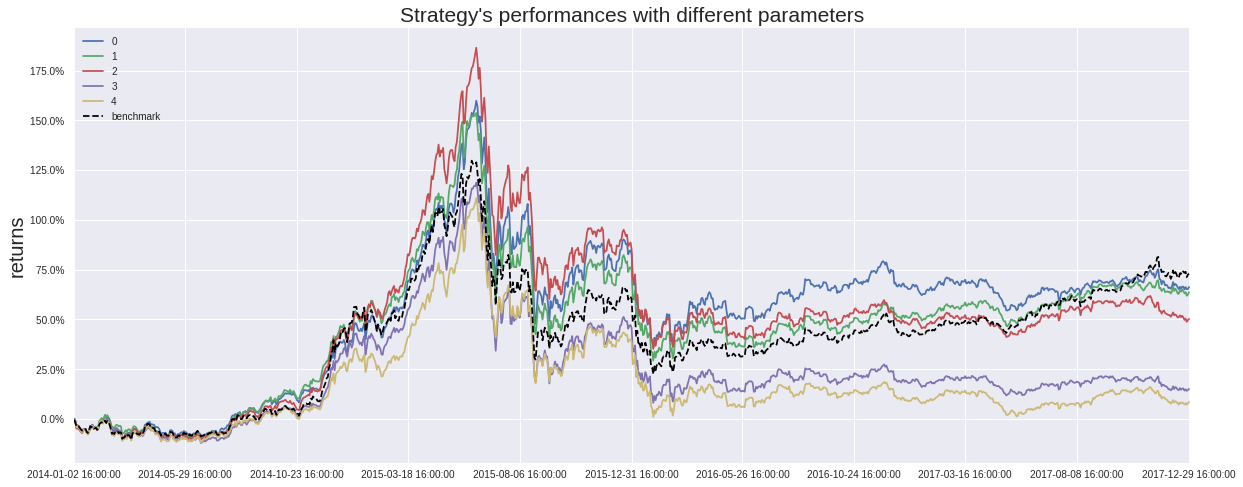

In [53]:
pa.plot_returns()


### 3.1.3 多空组合净值

从分层组合回测净值曲线图来看，每个组合波动性较大，策略存在较大的风险，因此考虑建立多空组合。多空组合是买入组合 1、卖空组合 5 (月度调仓)的一个资产组合，为了方便统计，多空组合每日收益率为（组合 1 每日收益率 - 组合 5 每日收益率）/2，然后获得多空组合的净值收益曲线，如图所示，多空组合净值收益曲线明显比任何一个组合的波动性更低，能够获得更为稳定的收益，风险控制效果较好。

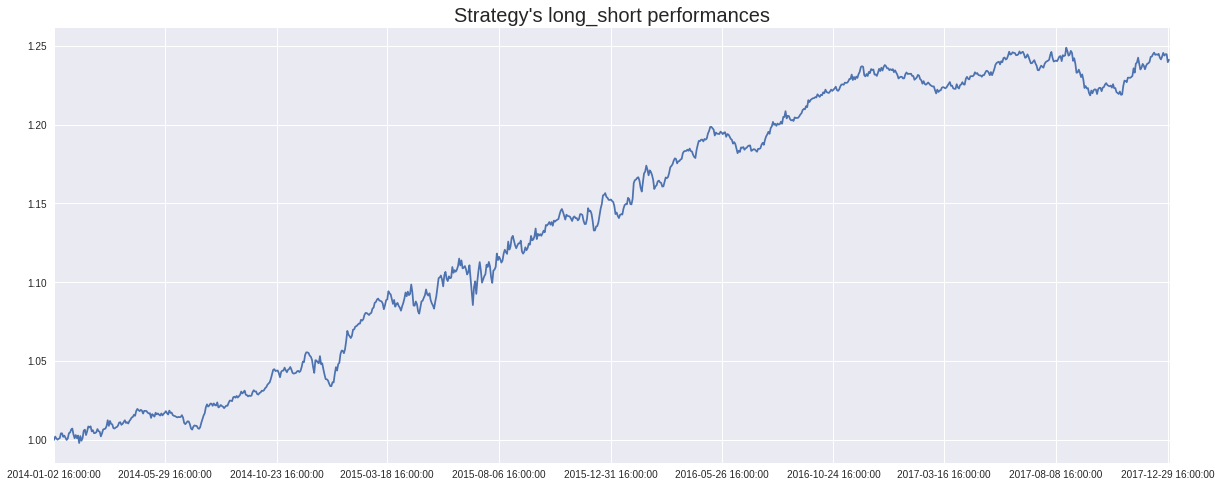

In [52]:
pa.plot_long_short()


### 3.1.4 不同年份的收益（分 5 层）

为了进一步分析模型的稳定性，对每一年每个组合的收益能力进行分析。如表所示，组合 1 每一年在 5 个组合中均能够获得较高的收益，而组合 5 基本上每年收益能力都排在最后两名。

In [119]:
pa.get_profit_year()


,2014,2015,2016,2017
0,0.4105758,0.2951192,-0.09466047,0.005677821
1,0.4732547,0.1858136,-0.1342327,0.08222096
2,0.4747881,0.2574169,-0.2027455,0.01625754
3,0.378217,0.05887626,-0.1896645,-0.02650093
4,0.309958,0.05923739,-0.2139513,-0.004814716


### 3.1.5 高斯核 SVM 模型策略组合回测分析表

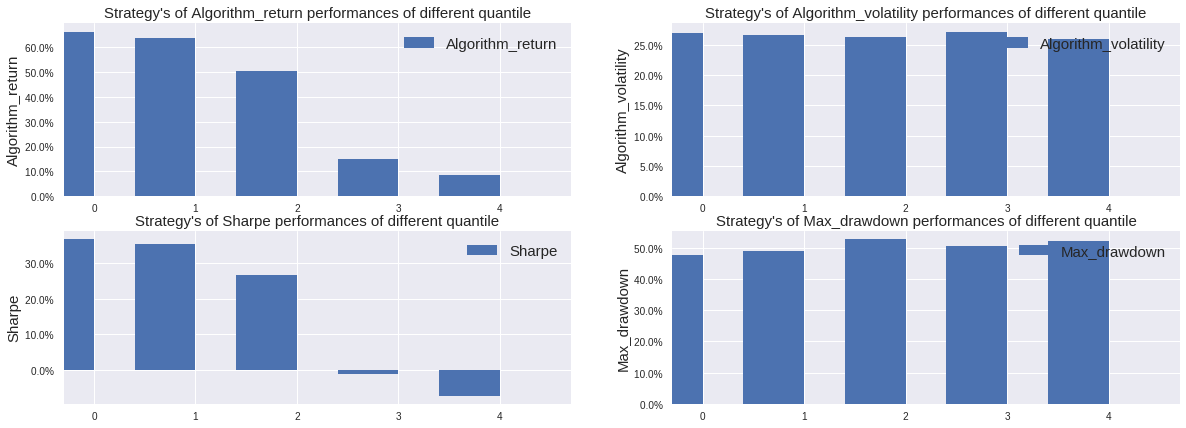

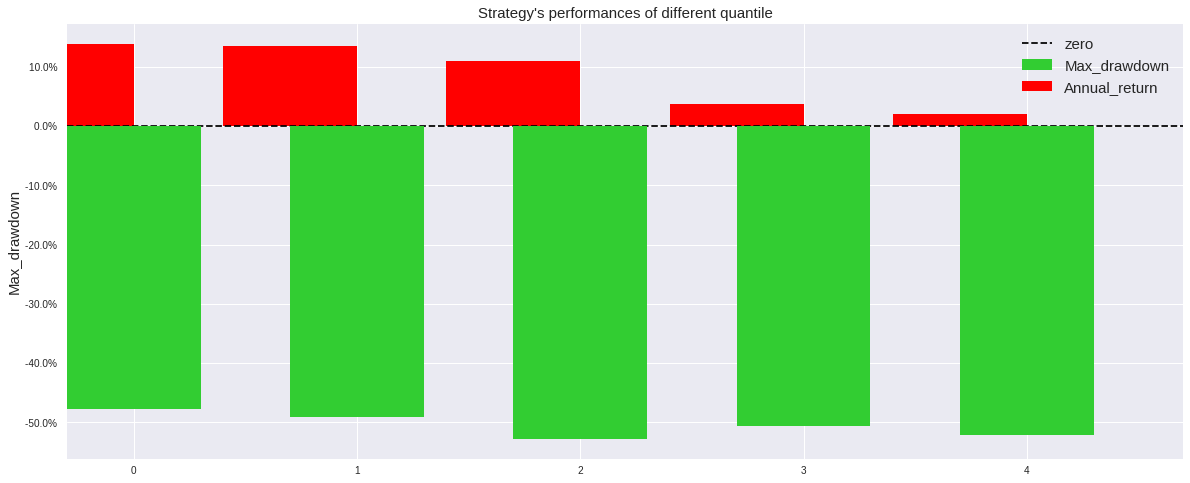

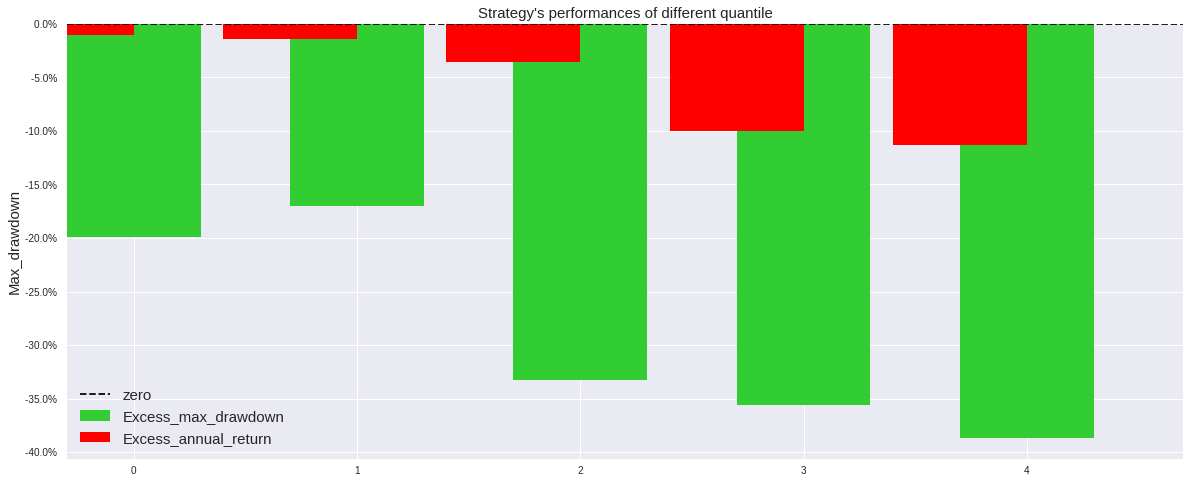

In [116]:
pa.get_eval4_bar()
pa.get_eval()
pa.get_excess_eval()

### 3.2 行业中性选股（约 20 min）

策略步骤：  
（1）所有股票归属申万一级行业  
（2）行业内股票按每月预测结果进行排序   
（3）行业内股票均分成 N层 (N=5)  
（4）每个分层组合的股票进行权重配置  
股票权重配置方法：  
在每个一级行业内部对所有个股按因子大小进行排序，每个行业内均分成 N 个分层组合。如图所示，黄色方块代表各行业内个股初始权重，可以相等也 可以不等(我们直接取相等权重进行测试)，分层具体操作方法为 N 等分行业内个股 权重累加值，例如图示行业 1 中，5 只个股初始权重相等(不妨设每只个股权重为 0.2)， 假设我们欲分成 3 层，则分层组合 1 在权重累加值 1/3 处截断，即分层组合 1 包含个股 1 和个股 2，它们的权重配比为 0.2:(1/3-0.2)=3:2，同样推理，分层组合 2 包含个股 2、3、4，配比为(0.4-1/3):0.2:(2/3-0.6)=1:3:1，分层组合 4 包含个股 4、5，配比 为 2:3。以上方法是用来计算各个一级行业内部个股权重配比的，行业间权重配比与基准组合(我们使用沪深 300)相同，也即行业中性。
![股票权重配置](https://ws1.sinaimg.cn/large/8a6915b1gy1fwti9oqt10j21040jcgri.jpg)


In [120]:
def group_backtest(start_date,end_date,num):
    warnings.filterwarnings("ignore")
    pa = parameter_analysis()
    pa.get_backtest_data(file_name = 'results_2.pkl',
                          running_max = 10,
                          algorithm_id = 'cfdda35cfec3faa0f6bcb1ab9f0dc705',
                          start_date=start_date,
                          end_date=end_date,
                          frequency = 'day',
                          initial_cash = '10000000',
                          param_names = ['num'],
                          param_values = [num]                     
                          )
    
start_date = '2014-01-01' 
end_date = '2018-01-01' 
num = [1,2,3,4,5]
group_backtest(start_date,end_date,num)


### 3.2.1 分层回测策略模型收益指标

为了对模型的收益能力进行具体分析，将模型预测结果看成单因子，按照单因子有效性的测试方法，对模型的有效性进行测试，具体分析方法为：（1）根据预测结果按照从大到小的顺序进行排序；（2）将股票平均分为 5 等份，分别构成 5 个投资组合。具体每个组合的收益指标如下表所示。

In [121]:
pa = parameter_analysis()
pa.read_backtest_data('results_2.pkl')
pa.evaluations_df


,num,__version,algorithm_return,algorithm_volatility,alpha,annual_algo_return,annual_bm_return,avg_position_days,avg_trade_return,benchmark_return,...,max_drawdown_period,max_leverage,period_label,profit_loss_ratio,sharpe,sortino,trading_days,treasury_return,win_count,win_ratio
0,1,101,0.7384686,0.2558606,0.001236461,0.1520072,0.1505617,NaN,NaN,0.7299592,...,"[2015-06-12, 2016-01-28]",0,2017-12,NaN,0.4377664,0.4927436,977,0.1596712,NaN,NaN
1,2,101,0.4645399,0.258357,-0.04971195,0.1025556,0.1505617,NaN,NaN,0.7299592,...,"[2015-06-12, 2016-01-28]",0,2017-12,NaN,0.2421287,0.2693173,977,0.1596712,NaN,NaN
2,3,101,0.636647,0.2644417,-0.02062771,0.1343523,0.1505617,NaN,NaN,0.7299592,...,"[2015-06-12, 2016-01-28]",0,2017-12,NaN,0.3567982,0.4054078,977,0.1596712,NaN,NaN
3,4,101,0.2111841,0.265172,-0.1045997,0.05024896,0.1505617,NaN,NaN,0.7299592,...,"[2015-06-12, 2016-02-29]",0,2017-12,NaN,0.03865024,0.04309056,977,0.1596712,NaN,NaN
4,5,101,0.2392598,0.2521945,-0.0923833,0.05642553,0.1505617,163.0706,0.008710813,0.7299592,...,"[2015-06-12, 2017-05-23]",0,2017-12,1.154396,0.06513041,0.07467727,977,0.1596712,1588,0.4995282


### 3.2.2 分层回测净值

为了进一步更直观的对 5 个组合进行分析，绘制了 5 个组合及 HS300 基准的净值收益曲线，具体下图所示。由图可以看出，组合 1 能够明显跑赢组合 5 ，可见符合单因子有效性的检验，即模型证明是有效的。

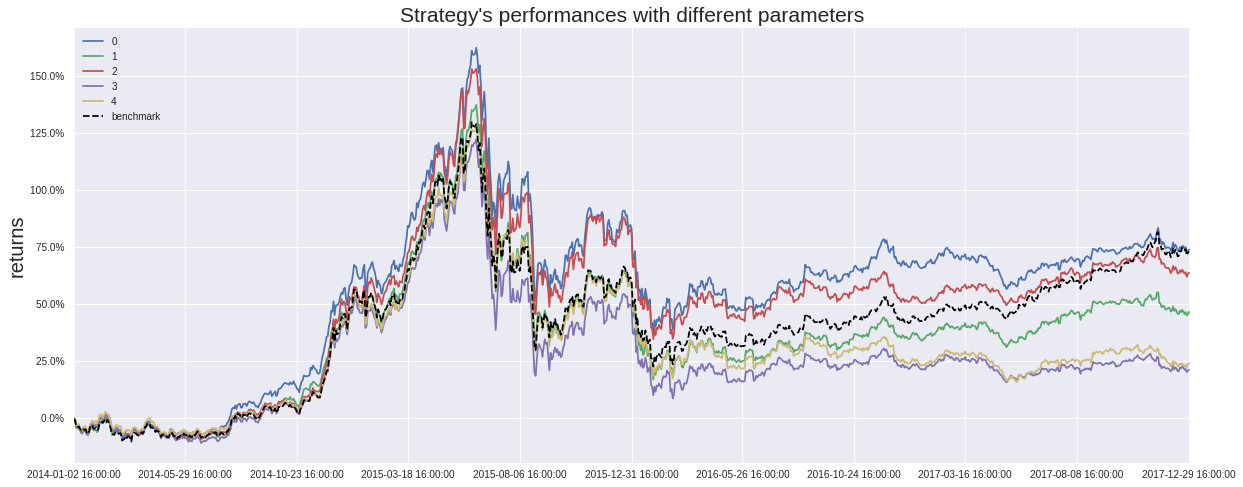

In [122]:
pa.plot_returns()


### 3.2.3 多空组合净值

从分层组合回测净值曲线图来看，每个组合波动性较大，策略存在较大的风险，因此考虑建立多空组合。多空组合是买入组合 1、卖空组合 5 (月度调仓)的一个资产组合，为了方便统计，多空组合每日收益率为（组合 1 每日收益率 - 组合 5 每日收益率）/2，然后获得多空组合的净值收益曲线，如图所示，多空组合净值收益曲线明显比任何一个组合的波动性更低，能够获得更为稳定的收益，风险控制效果较好。

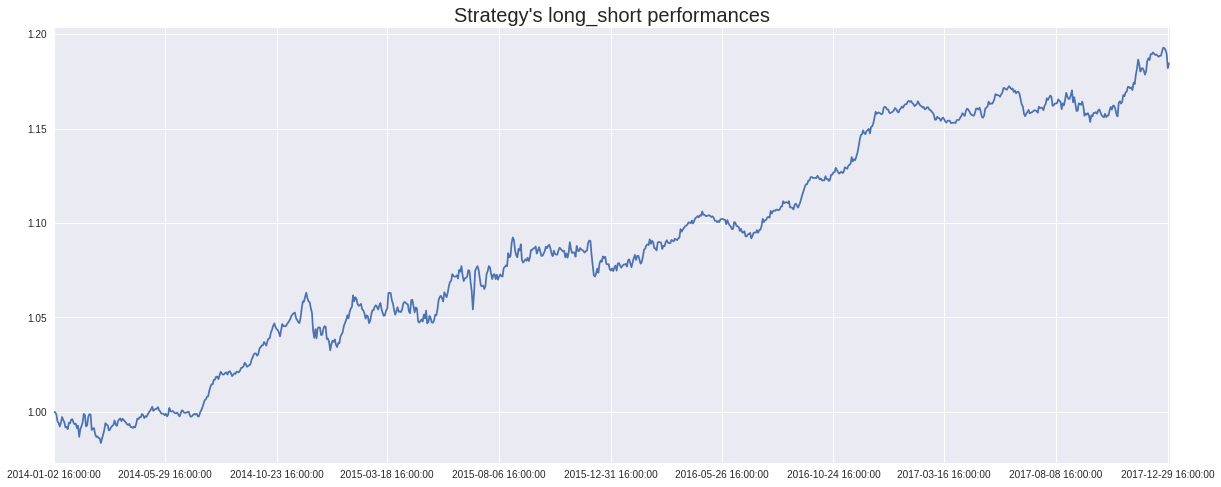

In [123]:
pa.plot_long_short()


### 3.2.4 不同年份的收益（分 5 层）

为了进一步分析模型的稳定性，对每一年每个组合的收益能力进行分析。如表所示，组合 1 每一年在 5 个组合中均能够获得较高的收益，而组合 5 基本上每年收益能力都排在最后两名。

In [124]:
pa.get_profit_year()


,2014,2015,2016,2017
0,0.6280222,0.123809,-0.09145536,0.04584604
1,0.490134,0.05852501,-0.1438406,0.08447645
2,0.5492871,0.1683142,-0.1643078,0.08197461
3,0.4815871,0.002071588,-0.1782878,-0.007193787
4,0.5115611,0.0472044,-0.2161214,-0.001250882


### 3.2.5 高斯核 SVM 模型策略组合回测分析表

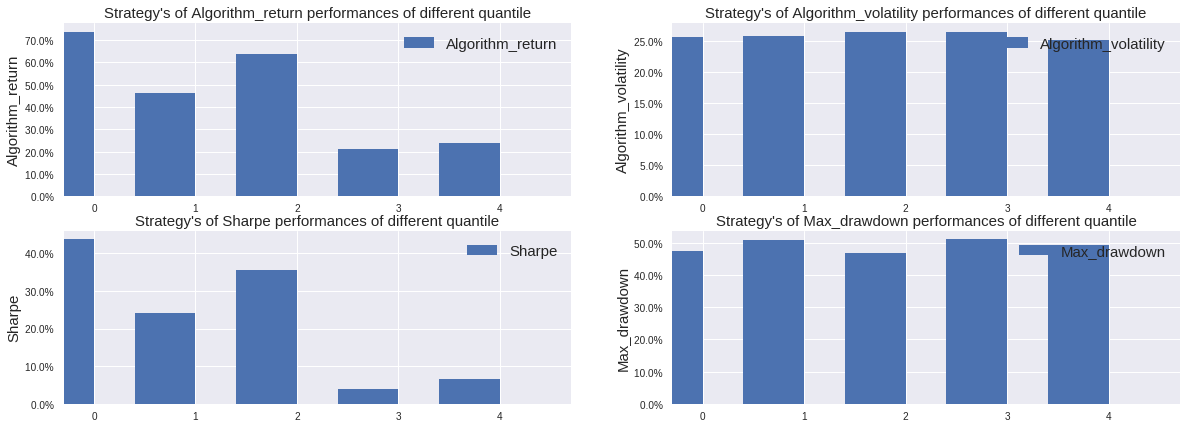

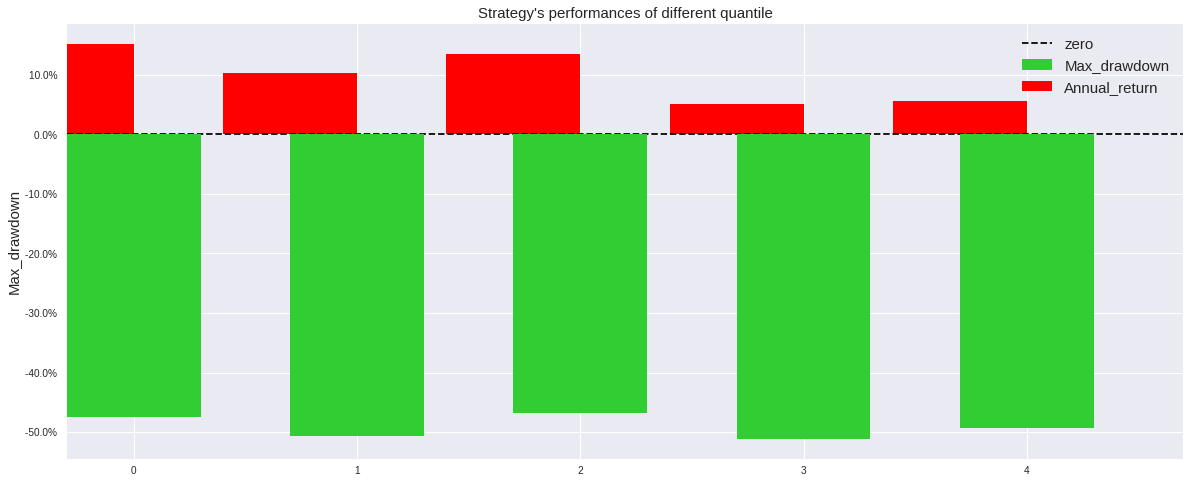

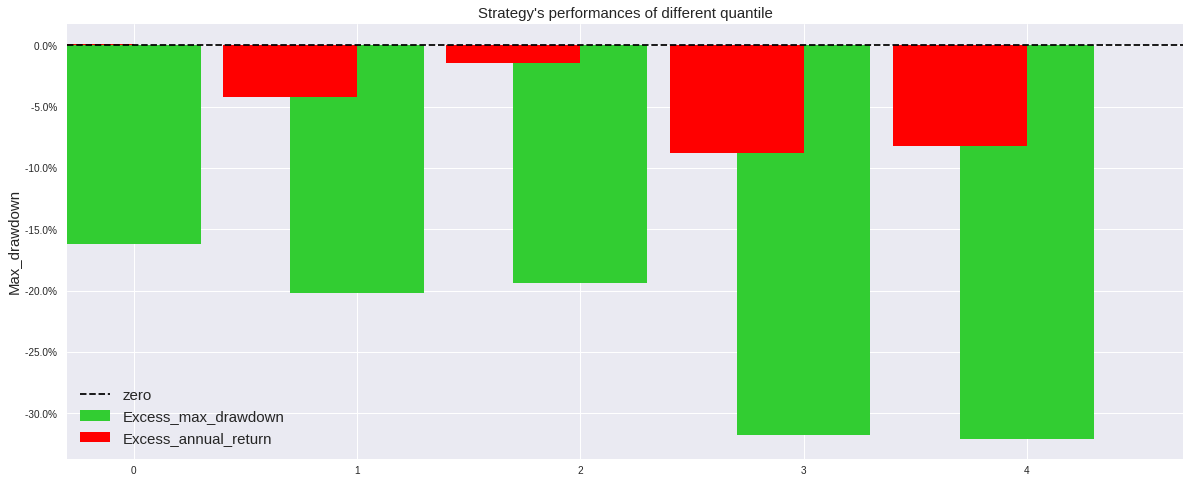

In [125]:
pa.get_eval4_bar()
pa.get_eval()
pa.get_excess_eval()


### 3.3 不同核函数 SVM 模型（等权重）（约 12 min）


策略步骤：  
（1）每月根据股票预测值进行排序  
（2）排序后，选择排名靠前的股票进行交易  
模型：  
（1）根据 SVM 模型核函数的不同，可分为不同的模型，具体参数设置如表所示  
（2）股票数量设定，分别选择 5%、10%、15%、20% 的股票数量进行交易，分析在交易股票数量下模型的收益能力。


| 序号 || 核函数 | 参数设定 |
| -----  || ----- | ------ | 
| 0 || 线性核 | C = 1e-4 | 
| 1 || 3 阶多项式核 | C = 0.003 gamma = 0.03 | 
| 2 || 7 阶多项式核 | C = 0.03  gamma = 0.01 | 
| 3 || 高斯核 | C = 1 gamma = 3e-5| 


### 3.3.1 策略构建

下面分别进行不同股票（5%、10%、15%、20%）的四个模型的构建，并将结果分别保存在文件（results_3.pkl','results_4.pkl','results_5.pkl','results_6.pkl'）中。

In [34]:
def group_backtest(start_date,end_date,para):
    warnings.filterwarnings("ignore")
    pa = parameter_analysis()
    pa.get_backtest_data(file_name = 'results_3.pkl',
                          running_max = 10,
                          algorithm_id = '8b3f1e1a95953fce81278dd280d0ee69',
                          start_date=start_date,
                          end_date=end_date,
                          frequency = 'day',
                          initial_cash = '10000000',
                          param_names = ['para'],
                          param_values = [para]                     
                          )
start_date = '2014-01-01' 
end_date = '2018-01-01' 

para = []
kernel = ['linear', 'poly', 'poly', 'rbf']
C = [1e-4, 0.003, 0.03, 1]
degree = [3, 3, 7, 3]
gamma = ['auto', 0.03, 0.01, 3e-5]
num = [0.05]*4
for i in range(len(kernel)):
    temp = {}
    temp['kernel'] = kernel[i]
    temp['C'] = C[i]
    temp['degree'] = degree[i]
    temp['gamma'] = gamma[i]
    temp['num'] = num[i]
    para.append(temp)
group_backtest(start_date,end_date,para)


 【已完成|运行中|待运行】: [0|0|4]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [1|3|0]. [1|3|0]. [1|3|0]. [1|3|0]. [1|3|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [3|1|0]. [3|1|0]. 
【回测完成】总用时：161秒(即0.04小时)。


In [35]:
def group_backtest(start_date,end_date,para):
    warnings.filterwarnings("ignore")
    pa = parameter_analysis()
    pa.get_backtest_data(file_name = 'results_4.pkl',
                          running_max = 10,
                          algorithm_id = '8b3f1e1a95953fce81278dd280d0ee69',
                          start_date=start_date,
                          end_date=end_date,
                          frequency = 'day',
                          initial_cash = '10000000',
                          param_names = ['para'],
                          param_values = [para]                     
                          )
start_date = '2014-01-01' 
end_date = '2018-01-01' 

para = []
kernel = ['linear', 'poly', 'poly', 'rbf']
C = [1e-4, 0.003, 0.03, 1]
degree = [3, 3, 7, 3]
gamma = ['auto', 0.03, 0.01, 3e-5]
num = [0.1]*4
for i in range(len(kernel)):
    temp = {}
    temp['kernel'] = kernel[i]
    temp['C'] = C[i]
    temp['degree'] = degree[i]
    temp['gamma'] = gamma[i]
    temp['num'] = num[i]
    para.append(temp)
group_backtest(start_date,end_date,para)


【已完成|运行中|待运行】: [0|0|4]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [1|3|0]. [2|2|0]. [3|1|0]. [3|1|0]. [3|1|0]. 
【回测完成】总用时：144秒(即0.04小时)。


In [36]:
def group_backtest(start_date,end_date,para):
    warnings.filterwarnings("ignore")
    pa = parameter_analysis()
    pa.get_backtest_data(file_name = 'results_5.pkl',
                          running_max = 10,
                          algorithm_id = '8b3f1e1a95953fce81278dd280d0ee69',
                          start_date=start_date,
                          end_date=end_date,
                          frequency = 'day',
                          initial_cash = '10000000',
                          param_names = ['para'],
                          param_values = [para]                     
                          )
start_date = '2014-01-01' 
end_date = '2018-01-01' 

para = []
kernel = ['linear', 'poly', 'poly', 'rbf']
C = [1e-4, 0.003, 0.03, 1]
degree = [3, 3, 7, 3]
gamma = ['auto', 0.03, 0.01, 3e-5]
num = [0.15]*4
for i in range(len(kernel)):
    temp = {}
    temp['kernel'] = kernel[i]
    temp['C'] = C[i]
    temp['degree'] = degree[i]
    temp['gamma'] = gamma[i]
    temp['num'] = num[i]
    para.append(temp)
group_backtest(start_date,end_date,para)


【已完成|运行中|待运行】: [0|0|4]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [1|3|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. 
【回测完成】总用时：216秒(即0.06小时)。


In [37]:
def group_backtest(start_date,end_date,para):
    warnings.filterwarnings("ignore")
    pa = parameter_analysis()
    pa.get_backtest_data(file_name = 'results_6.pkl',
                          running_max = 10,
                          algorithm_id = '8b3f1e1a95953fce81278dd280d0ee69',
                          start_date=start_date,
                          end_date=end_date,
                          frequency = 'day',
                          initial_cash = '10000000',
                          param_names = ['para'],
                          param_values = [para]                     
                          )
start_date = '2014-01-01' 
end_date = '2018-01-01' 

para = []
kernel = ['linear', 'poly', 'poly', 'rbf']
C = [1e-4, 0.003, 0.03, 1]
degree = [3, 3, 7, 3]
gamma = ['auto', 0.03, 0.01, 3e-5]
num = [0.2]*4
for i in range(len(kernel)):
    temp = {}
    temp['kernel'] = kernel[i]
    temp['C'] = C[i]
    temp['degree'] = degree[i]
    temp['gamma'] = gamma[i]
    temp['num'] = num[i]
    para.append(temp)
group_backtest(start_date,end_date,para)


【已完成|运行中|待运行】: [0|0|4]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [0|4|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. 
【回测完成】总用时：211秒(即0.06小时)。


### 3.3.2 不同核函数策略模型年化收益（不同股票数量）

In [38]:
files = ['results_3.pkl','results_4.pkl','results_5.pkl','results_6.pkl']
num = ['5%', '10%', '15%', '20%']
result = pd.DataFrame(index = ['线性核', '3 阶多项式核', '7 阶多项式核', '高斯核'])
pa = parameter_analysis()
for i in range(len(num)):
    pa.read_backtest_data(files[i])
    result[num[i]] = list(pa.evaluations_df['annual_algo_return'])
result


,5%,10%,15%,20%
线性核,0.180048,0.193814,0.185778,0.185456
3 阶多项式核,0.118267,0.106208,0.139193,0.159541
7 阶多项式核,0.075876,-0.051724,0.114701,0.109966
高斯核,0.180022,0.190774,0.186430,0.185224


横轴代表选择的股票占所有股票的百分比，纵轴代表不同的核函数

### 3.3.3 不同核函数策略模型夏普比率（不同股票数量）

In [39]:
files = ['results_3.pkl','results_4.pkl','results_5.pkl','results_6.pkl']
num = ['5%', '10%', '15%', '20%']
result = pd.DataFrame(index = ['线性核', '3 阶多项式核', '7 阶多项式核', '高斯核'])
pa = parameter_analysis()
for i in range(len(num)):
    pa.read_backtest_data(files[i])
    result[num[i]] = list(pa.evaluations_df['sharpe'])
result


,5%,10%,15%,20%
线性核,0.551065,0.601520,0.570711,0.566373
3 阶多项式核,0.320057,0.265304,0.398270,0.473421
7 阶多项式核,0.155162,-0.303734,0.312082,0.286605
高斯核,0.550939,0.588754,0.573654,0.565425


### 3.3.4 不同核函数策略模型最大回撤（不同股票数量）

In [40]:
files = ['results_3.pkl','results_4.pkl','results_5.pkl','results_6.pkl']
num = ['5%', '10%', '15%', '20%']
result = pd.DataFrame(index = ['线性核', '3 阶多项式核', '7 阶多项式核', '高斯核'])
pa = parameter_analysis()
for i in range(len(num)):
    pa.read_backtest_data(files[i])
    result[num[i]] = list(pa.evaluations_df['max_drawdown'])
result


,5%,10%,15%,20%
线性核,0.399281,0.419444,0.433982,0.442570
3 阶多项式核,0.433831,0.484936,0.451700,0.454899
7 阶多项式核,0.491758,0.665591,0.478805,0.485196
高斯核,0.399281,0.419937,0.433977,0.443329


### 3.3.5 不同核函数策略模型信息比率（不同股票数量）

In [41]:
files = ['results_3.pkl','results_4.pkl','results_5.pkl','results_6.pkl']
num = ['5%', '10%', '15%', '20%']
result = pd.DataFrame(index = ['线性核', '3 阶多项式核', '7 阶多项式核', '高斯核'])
pa = parameter_analysis()
for i in range(len(num)):
    pa.read_backtest_data(files[i])
    result[num[i]] = list(pa.evaluations_df['information'])
result


,5%,10%,15%,20%
线性核,0.270911,0.451676,0.412560,0.421594
3 阶多项式核,-0.274820,-0.464094,-0.128740,0.108245
7 阶多项式核,-0.636805,-1.365538,-0.396297,-0.479084
高斯核,0.270421,0.418434,0.419867,0.418307


通过不同模型的年化收益、夏普比率、最大回撤及信息比率来看，线性核和高斯核很明具有更好的收益，且当选择股票数量为 10% 时能够获得最高的收益，5% 时收益最差，可见，股票数量不是越少收益能力越强，数量过少容易导致风险不能被分散，从而使得模型承受更大的风险，导致收益能力下降。

## 3.4 SVR 模型和 SVM 模型（等权重）（约 10 min）


策略步骤：  
（1）每月根据股票预测值进行排序  
（2）排序后，选择排名靠前的股票进行交易  
模型：  
（1）根据 SVM 模型的不同，可分为不同的模型，具体参数设置如表所示  
（2）股票数量设定，分别选择 5%、10%、15%、20% 的股票数量进行交易，分析在交易股票数量下模型的收益能力。


| 序号 || 模型 | 参数设定 |
| -----  || ----- | ------ | 
| 0 || SVC | C = 10 gamma = 0.01 kernel = 'rbf' | 
| 1 || SVR | C = 10 gamma = 0.01 kernel = 'rbf' | 

### 3.4.1 策略构建

下面分别进行不同股票（5%、10%、15%、20%）的四个模型的构建，并将结果分别保存在文件（results_7.pkl','results_8.pkl','results_9.pkl','results_10.pkl'）中。

In [18]:
def group_backtest(start_date,end_date,types,num):
    warnings.filterwarnings("ignore")
    pa = parameter_analysis()
    pa.get_backtest_data(file_name = 'results_7.pkl',
                          running_max = 10,
                          algorithm_id = 'c0da7e0e37927fe2f196afae0d3dcd40',
                          start_date=start_date,
                          end_date=end_date,
                          frequency = 'day',
                          initial_cash = '10000000',
                          param_names = ['types','num'],
                          param_values = [types, num]                     
                          )
start_date = '2014-01-01' 
end_date = '2018-01-01' 

para = []
types = ['SVC', 'SVR']
num = [0.05]
group_backtest(start_date,end_date,types,num)


 【已完成|运行中|待运行】: [0|0|2]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. 
【回测完成】总用时：142秒(即0.04小时)。


In [19]:
def group_backtest(start_date,end_date,types,num):
    warnings.filterwarnings("ignore")
    pa = parameter_analysis()
    pa.get_backtest_data(file_name = 'results_8.pkl',
                          running_max = 10,
                          algorithm_id = 'c0da7e0e37927fe2f196afae0d3dcd40',
                          start_date=start_date,
                          end_date=end_date,
                          frequency = 'day',
                          initial_cash = '10000000',
                          param_names = ['types','num'],
                          param_values = [types, num]                     
                          )
start_date = '2014-01-01' 
end_date = '2018-01-01' 

para = []
types = ['SVC', 'SVR']
num = [0.1]
group_backtest(start_date,end_date,types,num)


【已完成|运行中|待运行】: [0|0|2]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [1|1|0]. [1|1|0]. [1|1|0]. 
【回测完成】总用时：122秒(即0.03小时)。


In [20]:
def group_backtest(start_date,end_date,types,num):
    warnings.filterwarnings("ignore")
    pa = parameter_analysis()
    pa.get_backtest_data(file_name = 'results_9.pkl',
                          running_max = 10,
                          algorithm_id = 'c0da7e0e37927fe2f196afae0d3dcd40',
                          start_date=start_date,
                          end_date=end_date,
                          frequency = 'day',
                          initial_cash = '10000000',
                          param_names = ['types','num'],
                          param_values = [types, num]                     
                          )
start_date = '2014-01-01' 
end_date = '2018-01-01' 

para = []
types = ['SVC', 'SVR']
num = [0.15]
group_backtest(start_date,end_date,types,num)


【已完成|运行中|待运行】: [0|0|2]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. 
【回测完成】总用时：160秒(即0.04小时)。


In [21]:
def group_backtest(start_date,end_date,types,num):
    warnings.filterwarnings("ignore")
    pa = parameter_analysis()
    pa.get_backtest_data(file_name = 'results_10.pkl',
                          running_max = 10,
                          algorithm_id = 'c0da7e0e37927fe2f196afae0d3dcd40',
                          start_date=start_date,
                          end_date=end_date,
                          frequency = 'day',
                          initial_cash = '10000000',
                          param_names = ['types','num'],
                          param_values = [types, num]                     
                          )
start_date = '2014-01-01' 
end_date = '2018-01-01' 

para = []
types = ['SVC', 'SVR']
num = [0.2]
group_backtest(start_date,end_date,types,num)


【已完成|运行中|待运行】: [0|0|2]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [0|2|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. [1|1|0]. 
【回测完成】总用时：203秒(即0.06小时)。


### 3.4.2 SVR 模型和 SVM 模型年化收益（不同股票数量）

In [22]:
files = ['results_7.pkl','results_8.pkl','results_9.pkl','results_10.pkl']
num = ['5%', '10%', '15%', '20%']
result = pd.DataFrame(index = ['SVC', 'SVR'])
pa = parameter_analysis()
for i in range(len(num)):
    pa.read_backtest_data(files[i])
    result[num[i]] = list(pa.evaluations_df['annual_algo_return'])
result


,5%,10%,15%,20%
SVC,0.071951,0.126097,0.148496,0.139055
SVR,0.085703,0.125346,0.117887,0.137773


### 3.4.3 SVR 模型和 SVM 模型夏普比率（不同股票数量）

In [25]:
files = ['results_7.pkl','results_8.pkl','results_9.pkl','results_10.pkl']
num = ['5%', '10%', '15%', '20%']
result = pd.DataFrame(index = ['SVC', 'SVR'])
pa = parameter_analysis()
for i in range(len(num)):
    pa.read_backtest_data(files[i])
    result[num[i]] = list(pa.evaluations_df['sharpe'])
result


,5%,10%,15%,20%
SVC,0.115618,0.310074,0.403821,0.367722
SVR,0.166291,0.311041,0.291229,0.366917


### 3.4.4 SVR 模型和 SVM 模型最大回撤（不同股票数量）

In [26]:
files = ['results_7.pkl','results_8.pkl','results_9.pkl','results_10.pkl']
num = ['5%', '10%', '15%', '20%']
result = pd.DataFrame(index = ['SVC', 'SVR'])
pa = parameter_analysis()
for i in range(len(num)):
    pa.read_backtest_data(files[i])
    result[num[i]] = list(pa.evaluations_df['max_drawdown'])
result


,5%,10%,15%,20%
SVC,0.481083,0.496830,0.464156,0.477222
SVR,0.466013,0.476128,0.473968,0.473292


### 3.4.5 SVR 模型和 SVM 模型信息比率（不同股票数量）

In [27]:
files = ['results_7.pkl','results_8.pkl','results_9.pkl','results_10.pkl']
num = ['5%', '10%', '15%', '20%']
result = pd.DataFrame(index = ['SVC', 'SVR'])
pa = parameter_analysis()
for i in range(len(num)):
    pa.read_backtest_data(files[i])
    result[num[i]] = list(pa.evaluations_df['information'])
result


,5%,10%,15%,20%
SVC,-0.676139,-0.246785,-0.022625,-0.133438
SVR,-0.594407,-0.267845,-0.369962,-0.153159


通过不同模型的年化收益、夏普比率、最大回撤及信息比率来看，SVC 模型很明具有更好的收益，且当选择股票数量为 15% 时 SVC 模型能够获得最高的收益，年化收益达到 14.85%，且夏普比率及信息比率均在所有模型中为最大值，此外，从风险指标最大回撤来看，该模型的最大回撤最小，可见该模型不仅收益能力最强，且风险控制能力也最强。接下来，我们选择股票数量为 15%，分别构建高斯核 SVM 模型和 SVR 模型的收益曲线，更直观地对模型进行分析。

### 3.4.6 高斯核 SVM 模型和 SVR 模型收益曲线（股票数量 15%）

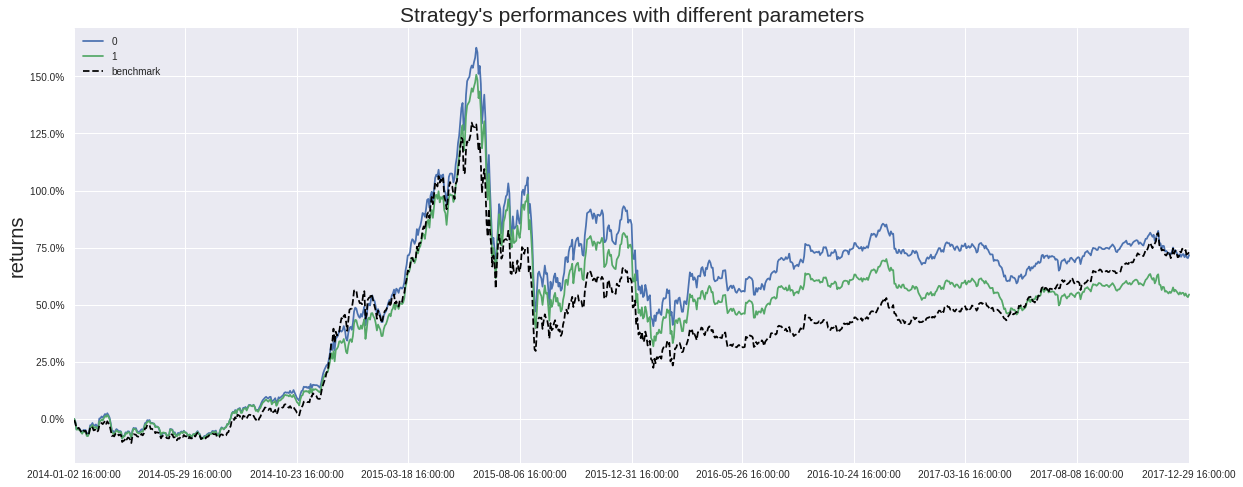

In [42]:
pa = parameter_analysis()
pa.read_backtest_data('results_9.pkl')
pa.plot_returns()


### 3.4.7 高斯核 SVM 模型和 SVR 模型超额收益曲线（股票数量 15%）

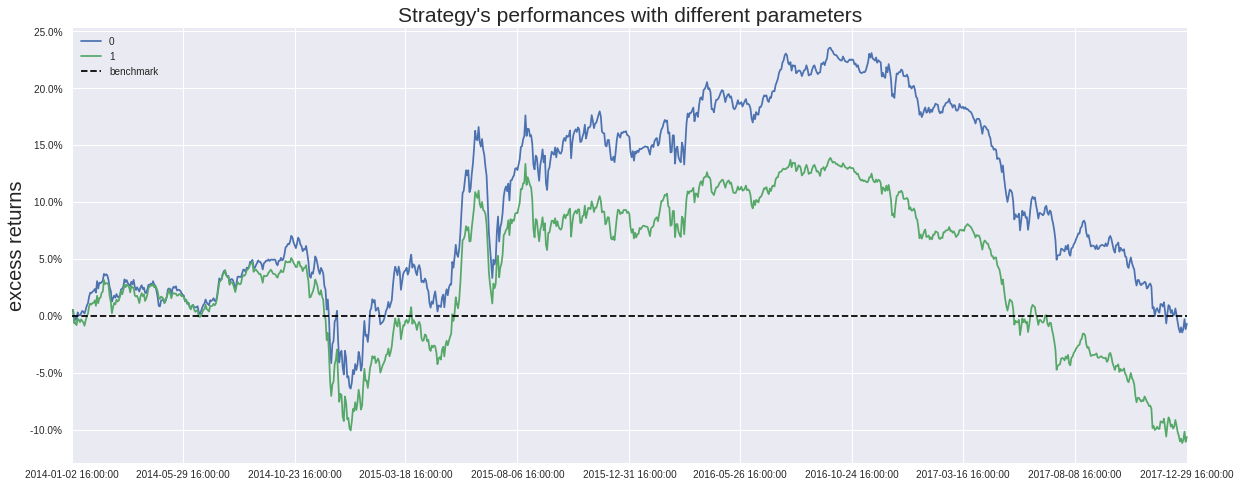

In [45]:
pa.plot_excess_returns()

## 3.5 小结

本部分以 HS300 成分股为股票池，将 2010-2014 年数据作为训练集构建不同模型，在 2014-2018 年进行策略回测，最后通过对策略的收益能力及风险控制能力的分析评价模型的优劣。首先，构建高斯核 SVM 模型进行分层回测，分别进行等权重选股及行业中性策略，结果表明高斯核模型是有效的；紧接着，对不同核模型，分别进行不同股票数量的回测，结果表明线性核和高斯核的收益能力更强，且选择股票数量为 10% 时能够获得最高的收益；最后，对 SVC 模型及 SVR 模型进行分析，结果表明 SVC 模型表现效果更好。

# 总结

以上我们对支持向量机进行了系统的测试，并且利用支持向量机模型构建沪深 300 选股策略，初步得到以下几个结论:  
一、SVM 具备不错的预测能力。我们以 2010-2014 年的因子及下期收益作为样本内集合， 2014 年 2018 年的数据为样本外测试集，高斯核 SVM 在 HS300 选股模型交叉验证集正确率为 56.2%，AUC 为 0.561，样本外测试集平均正确率为 55.1%，平均 AUC 为 0.550。  
二、我们分别以 HS300 为股票池，利用高斯核 SVM 模型构建选股策略。对于 HS300 成份股内选股的等权重策略以及行业中性策略。总体而言，高斯核 SVM 在收益、夏普比率、最大回撤等方面分层明确，可见模型是有效的。  
三、由此我们也可以推知，对于固定训练集的机器学习模型，训练集的选择至关重要，需要尽可能囊括市场风格的各种可能性。训练集时间长度不能过短，并且应包含至少一个经济周期，我们选择 2010~2014 年作为训练集正是出于上述考虑。然而类似 2014 年 12 月以及 2017 年上半年市场风格巨变的情况在历史上发生的次数不多，在训练集时间段中没有出现过，因此固定训练集的模型出现较大回撤在我们的预料之中。  
四、我们比较了高斯核支持向量机 (SVM) 以及支持向量回归 (SVR) 的预测能力。绝大多数时候，高斯核 SVC 的收益能力比 SVR 模型更强，可能的原因在于，对原始收益率进行二值化处理，分成正例和反例后，尽管损失了部分信息，但同时消除了收益率信息中包含的大量噪音，使得模型能够更准确地捕捉数据中蕴含的规律。  
五、我们比较了不同核支持向量机 (SVM) 的预测能力。绝大多数时候，高斯核收益能力要高于其他核函数模型。作为使用最为广泛的核函数，其优势在于不对原始数据做太多的先验假设。高斯核 SVM 假设原始数据线性可分，换言之因子和收益率之间存在线性关系。